In [1]:

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import warnings

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.preprocessing import QuantileTransformer, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import matthews_corrcoef

from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedShuffleSplit
from xgboost import XGBClassifier
import optuna

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')





In [2]:
train=pd.read_csv('/kaggle/input/playground-series-s4e8/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e8/test.csv')
train['dataset'] = 'train'
test['dataset'] = 'test'
sample_sub = pd.read_csv("/kaggle/input/playground-series-s4e8/sample_submission.csv")

df_ = pd.concat([train, test], sort=False)
df=df_.copy()

In [3]:
train.shape

(3116945, 23)

In [4]:
df.columns

Index(['id', 'class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season', 'dataset'], dtype='object')

In [5]:
df.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season,dataset
0,0,e,8.80,f,s,u,f,a,c,w,4.51,15.39,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a,train
1,1,p,4.51,x,h,o,f,a,c,n,4.79,6.48,NaN,y,o,NaN,NaN,t,z,NaN,d,w,train
2,2,e,6.94,f,s,b,f,x,c,w,6.85,9.93,NaN,s,n,NaN,NaN,f,f,NaN,l,w,train
3,3,e,3.88,f,y,g,f,s,NaN,g,4.16,6.53,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u,train
4,4,e,5.85,x,l,w,f,d,NaN,w,3.37,8.36,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a,train


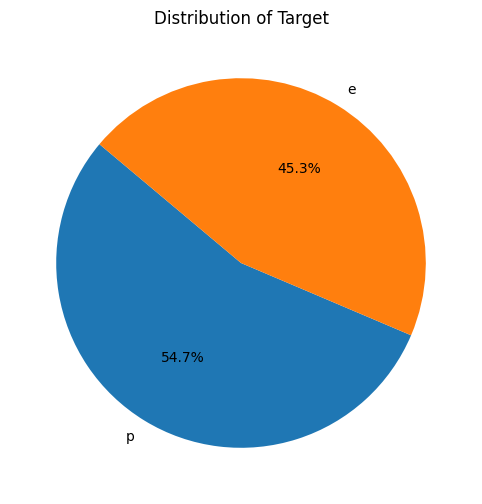

In [6]:
value_counts = df['class'].value_counts()
percentages = 100 * value_counts / len(df)

plt.figure(figsize=(8, 6))
plt.pie(percentages, labels=percentages.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Target')
plt.show()

In [7]:
df['class'] = df['class'].replace({'e': 0, 'p': 1 })

In [8]:
df

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season,dataset
0,0,0.0,8.80,f,s,u,f,a,c,w,4.51,15.39,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a,train
1,1,1.0,4.51,x,h,o,f,a,c,n,4.79,6.48,NaN,y,o,NaN,NaN,t,z,NaN,d,w,train
2,2,0.0,6.94,f,s,b,f,x,c,w,6.85,9.93,NaN,s,n,NaN,NaN,f,f,NaN,l,w,train
3,3,0.0,3.88,f,y,g,f,s,NaN,g,4.16,6.53,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u,train
4,4,0.0,5.85,x,l,w,f,d,NaN,w,3.37,8.36,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077959,5194904,NaN,0.88,x,g,w,f,a,d,w,2.67,1.35,NaN,NaN,e,NaN,NaN,f,f,NaN,d,u,test
2077960,5194905,NaN,3.12,x,s,w,f,d,c,w,2.69,7.38,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a,test
2077961,5194906,NaN,5.73,x,e,e,f,a,NaN,w,6.16,9.74,NaN,NaN,y,NaN,w,t,z,NaN,d,a,test
2077962,5194907,NaN,5.03,b,g,n,f,a,d,g,6.00,3.46,NaN,s,g,NaN,NaN,f,f,NaN,d,a,test


In [9]:
df.shape

(5194909, 23)

In [10]:
df.nunique()

id                      5194909
class                         2
cap-diameter               4145
cap-shape                   108
cap-surface                 114
cap-color                   109
does-bruise-or-bleed         29
gill-attachment             117
gill-spacing                 66
gill-color                   86
stem-height                2858
stem-width                 6194
stem-root                    45
stem-surface                 87
stem-color                   88
veil-type                    24
veil-color                   27
has-ring                     26
ring-type                    47
spore-print-color            43
habitat                      65
season                        4
dataset                       2
dtype: int64

In [11]:
df.isnull().sum()

id                            0
class                   2077964
cap-diameter                 11
cap-shape                    71
cap-surface             1117927
cap-color                    25
does-bruise-or-bleed         18
gill-attachment          873757
gill-spacing            2098030
gill-color                  106
stem-height                   1
stem-width                    0
stem-root               4595035
stem-surface            3302349
stem-color                   59
veil-type               4929038
veil-color              4567071
has-ring                     43
ring-type                215075
spore-print-color       4749299
habitat                      70
season                        0
dataset                       0
dtype: int64

In [12]:
df.dtypes

id                        int64
class                   float64
cap-diameter            float64
cap-shape                object
cap-surface              object
cap-color                object
does-bruise-or-bleed     object
gill-attachment          object
gill-spacing             object
gill-color               object
stem-height             float64
stem-width              float64
stem-root                object
stem-surface             object
stem-color               object
veil-type                object
veil-color               object
has-ring                 object
ring-type                object
spore-print-color        object
habitat                  object
season                   object
dataset                  object
dtype: object

In [13]:
def replace_non_alpha_with_nan(df):
    object_columns = [col for col in df.columns if df[col].dtype == 'object' and col!='dataset']
    alphabet_list = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
    def filter_alpha(value):
        if isinstance(value, str):
            return value if len(value) == 1 and value in alphabet_list else np.nan
        return np.nan
    for col in object_columns:
        df[col] = df[col].apply(filter_alpha)
    return df
    

In [14]:
df = replace_non_alpha_with_nan(df)

In [15]:
df.nunique()


id                      5194909
class                         2
cap-diameter               4145
cap-shape                    23
cap-surface                  23
cap-color                    23
does-bruise-or-bleed         23
gill-attachment              23
gill-spacing                 20
gill-color                   23
stem-height                2858
stem-width                 6194
stem-root                    23
stem-surface                 23
stem-color                   23
veil-type                    20
veil-color                   22
has-ring                     23
ring-type                    23
spore-print-color            23
habitat                      23
season                        4
dataset                       2
dtype: int64

In [16]:
df.isnull().sum()

id                            0
class                   2077964
cap-diameter                 11
cap-shape                   166
cap-surface             1118041
cap-color                   139
does-bruise-or-bleed         24
gill-attachment          873863
gill-spacing            2098079
gill-color                  217
stem-height                   1
stem-width                    0
stem-root               4595058
stem-surface            3302436
stem-color                  133
veil-type               4929042
veil-color              4567076
has-ring                     46
ring-type                215118
spore-print-color       4749321
habitat                     139
season                        0
dataset                       0
dtype: int64

In [17]:
def grab_col_names(dataframe,cat_th=10,car_th=30):
    cat_cols=[col for col in dataframe.columns if dataframe[col].dtypes=='object' and col!='dataset']
    num_but_cat=[col for col in dataframe.columns if dataframe[col].dtypes!='O' and dataframe[col].nunique() < cat_th]
    cat_but_car=[col for col in dataframe.columns if dataframe[col].dtypes=='O' and dataframe[col].nunique()>car_th and col!='dataset']
    cat_cols=cat_cols+num_but_cat
    num_cols=[col for col in dataframe.columns if dataframe[col].dtypes!='O']
    num_cols=[col for col in num_cols if col not in num_but_cat]
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 5194909
Variables: 23
cat_cols: 18
num_cols: 4
cat_but_car: 0
num_but_cat: 1


In [18]:
cat_cols = [col for col in cat_cols if col not in ["class",'dataset']]
num_cols = [col for col in num_cols if col not in ["id"]]

In [19]:
print(cat_cols)

['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']


# Analysis of categorical variables :

           cap-shape      Ratio
cap-shape                      
x            2393975  46.083098
f            1128598  21.725077
s             607844  11.700763
b             530525  10.212402
o             180807   3.480465
p             178269   3.431610
c             173956   3.348586
d                 95   0.001829
e                 93   0.001790
n                 68   0.001309
t                 64   0.001232
w                 63   0.001213
y                 57   0.001097
a                 54   0.001039
g                 51   0.000982
r                 48   0.000924
u                 45   0.000866
l                 38   0.000731
k                 30   0.000577
z                 30   0.000577
i                 18   0.000346
h                  9   0.000173
m                  6   0.000115
##########################################


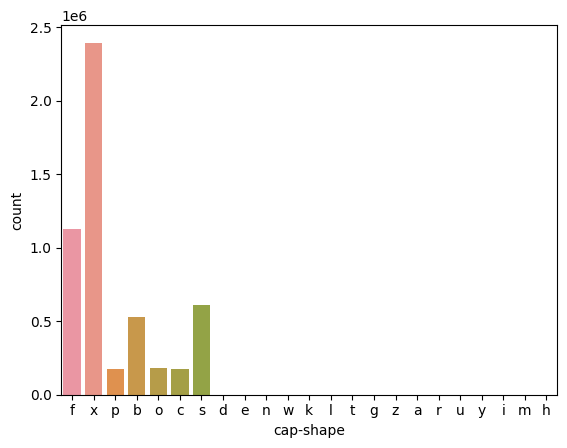

             cap-surface      Ratio
cap-surface                        
t                 767629  14.776563
s                 642160  12.361333
y                 546162  10.513408
h                 474197   9.128110
g                 439869   8.467309
d                 344507   6.631627
k                 214916   4.137050
e                 199630   3.842801
i                 189010   3.638370
w                 182949   3.521698
l                  74960   1.442951
n                    146   0.002810
f                    129   0.002483
p                    103   0.001983
o                     76   0.001463
a                     72   0.001386
u                     70   0.001347
m                     67   0.001290
r                     60   0.001155
x                     60   0.001155
c                     50   0.000962
b                     32   0.000616
z                     14   0.000269
##########################################


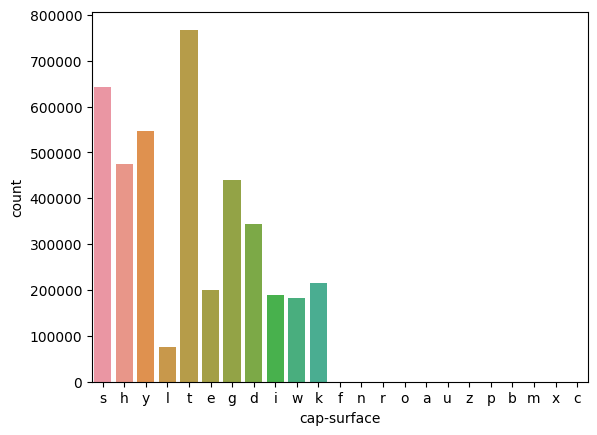

           cap-color      Ratio
cap-color                      
n            2263849  43.578222
y             645689  12.429265
w             633286  12.190512
g             351506   6.766355
e             328814   6.329543
o             298611   5.748147
p             153024   2.945653
r             130020   2.502835
u             122037   2.349165
b             102103   1.965443
k              99503   1.915394
l              65819   1.266990
f                 98   0.001886
d                 88   0.001694
a                 66   0.001270
s                 59   0.001136
t                 42   0.000808
h                 35   0.000674
i                 29   0.000558
x                 28   0.000539
c                 26   0.000500
m                 20   0.000385
z                 18   0.000346
##########################################


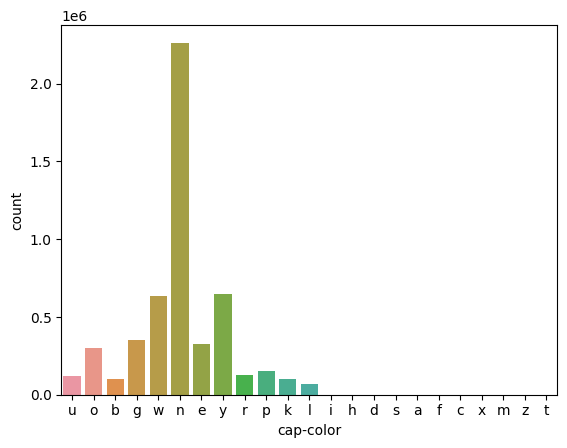

                      does-bruise-or-bleed      Ratio
does-bruise-or-bleed                                 
f                                  4283405  82.453899
t                                   911312  17.542405
w                                       21   0.000404
x                                       18   0.000346
c                                       14   0.000269
h                                       13   0.000250
s                                       13   0.000250
k                                        9   0.000173
a                                        9   0.000173
p                                        9   0.000173
b                                        9   0.000173
y                                        8   0.000154
e                                        7   0.000135
g                                        6   0.000115
n                                        6   0.000115
o                                        6   0.000115
l                           

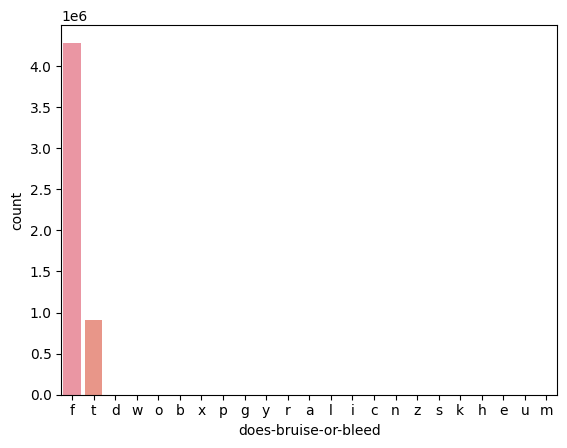

                 gill-attachment      Ratio
gill-attachment                            
a                        1076994  20.731720
d                         981820  18.899657
x                         601636  11.581262
e                         503134   9.685136
s                         491718   9.465382
p                         465444   8.959618
f                         199583   3.841896
c                            127   0.002445
u                             91   0.001752
w                             63   0.001213
t                             63   0.001213
k                             53   0.001020
y                             40   0.000770
i                             39   0.000751
g                             39   0.000751
n                             33   0.000635
b                             32   0.000616
o                             29   0.000558
m                             29   0.000558
l                             27   0.000520
h                             27

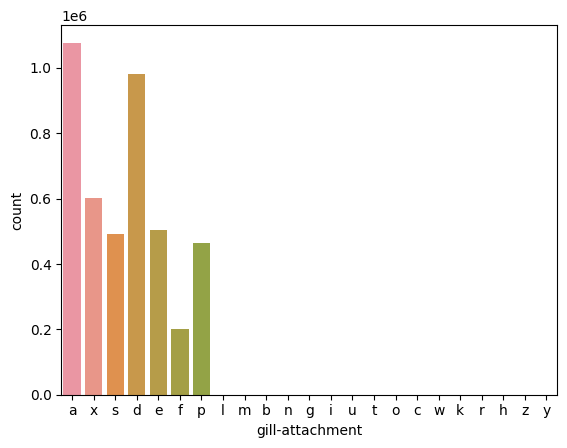

              gill-spacing      Ratio
gill-spacing                         
c                  2218030  42.696224
d                   680017  13.090066
f                   198603   3.823031
e                       35   0.000674
a                       27   0.000520
s                       26   0.000500
b                       19   0.000366
x                       14   0.000269
p                       12   0.000231
t                       10   0.000192
g                        7   0.000135
y                        6   0.000115
k                        5   0.000096
w                        5   0.000096
h                        3   0.000058
l                        3   0.000058
r                        3   0.000058
i                        2   0.000038
m                        2   0.000038
n                        1   0.000019
##########################################


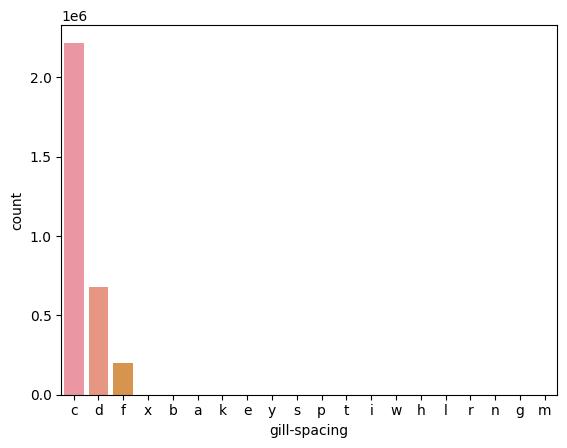

            gill-color      Ratio
gill-color                       
w              1552311  29.881390
n               905555  17.431585
y               783396  15.080072
p               572781  11.025814
g               353683   6.808262
o               262167   5.046614
k               213330   4.106520
f               199176   3.834061
r               104298   2.007696
e                93479   1.799435
b                78430   1.509747
u                75483   1.453019
l                   92   0.001771
d                   91   0.001752
t                   78   0.001501
s                   76   0.001463
x                   63   0.001213
c                   57   0.001097
a                   48   0.000924
h                   37   0.000712
z                   25   0.000481
m                   22   0.000423
i                   14   0.000269
##########################################


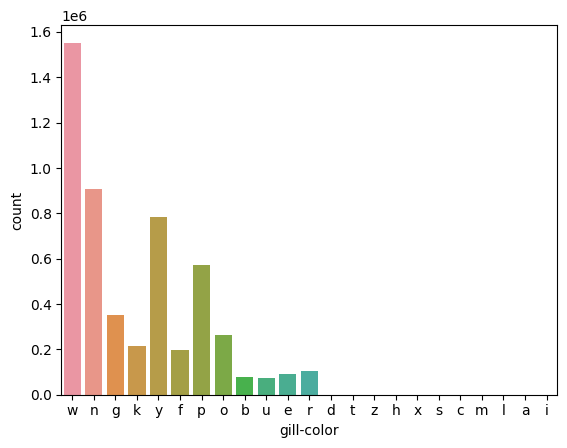

           stem-root     Ratio
stem-root                     
b             276382  5.320247
s             195199  3.757506
r              79409  1.528593
c              47617  0.916609
f                971  0.018691
d                 31  0.000597
y                 28  0.000539
g                 26  0.000500
p                 23  0.000443
w                 18  0.000346
l                 16  0.000308
t                 16  0.000308
u                 16  0.000308
k                 16  0.000308
e                 13  0.000250
x                 12  0.000231
a                 12  0.000231
i                 11  0.000212
n                 11  0.000212
o                 10  0.000192
m                  5  0.000096
h                  5  0.000096
z                  4  0.000077
##########################################


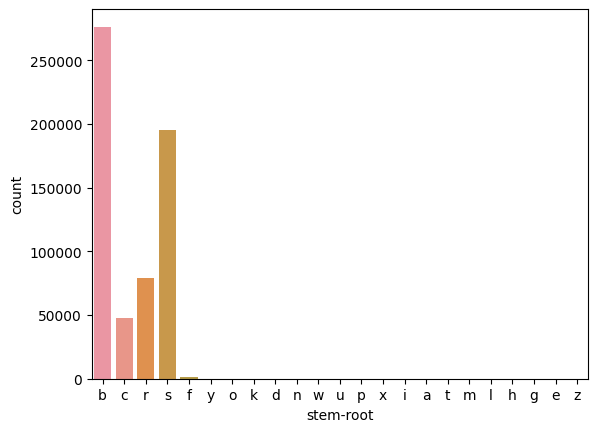

              stem-surface      Ratio
stem-surface                         
s                   546106  10.512330
y                   424962   8.180355
i                   373538   7.190463
t                   246956   4.753808
g                   129928   2.501064
k                   122458   2.357269
h                    47144   0.907504
f                      822   0.015823
d                       89   0.001713
w                       86   0.001655
e                       59   0.001136
n                       46   0.000885
r                       40   0.000770
x                       37   0.000712
c                       32   0.000616
p                       29   0.000558
u                       29   0.000558
l                       28   0.000539
b                       27   0.000520
o                       25   0.000481
a                       17   0.000327
m                       11   0.000212
z                        4   0.000077
##########################################


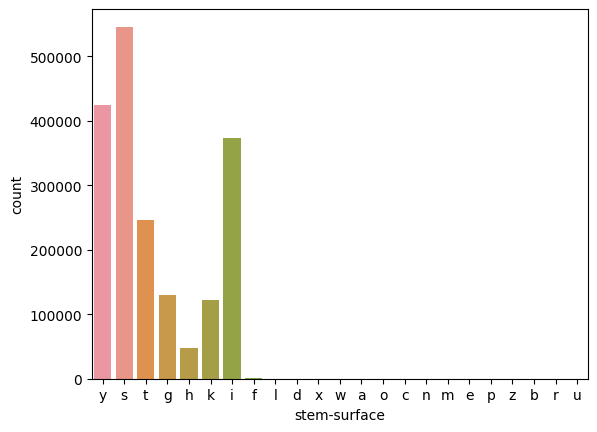

            stem-color      Ratio
stem-color                       
w              1994002  38.383771
n              1671620  32.178042
y               624112  12.013916
g               220221   4.239170
o               186635   3.592652
e               172177   3.314341
u               111801   2.152126
p                91046   1.752600
k                55852   1.075130
r                37239   0.716836
l                16512   0.317850
b                12260   0.236000
f                  928   0.017864
s                   86   0.001655
t                   61   0.001174
a                   57   0.001097
i                   40   0.000770
x                   37   0.000712
d                   28   0.000539
h                   24   0.000462
c                   15   0.000289
m                   14   0.000269
z                    9   0.000173
##########################################


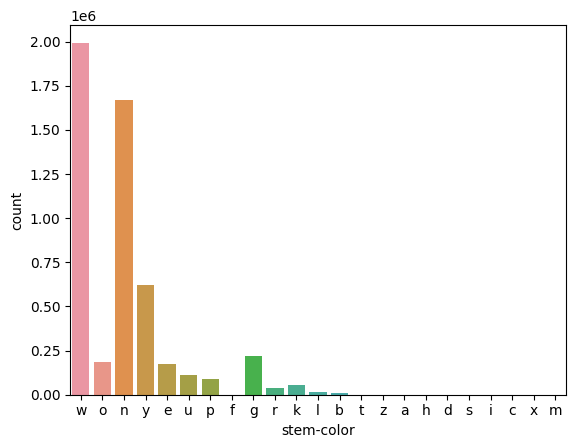

           veil-type     Ratio
veil-type                     
u             265746  5.115508
w                 23  0.000443
e                 14  0.000269
a                 11  0.000212
k                  9  0.000173
f                  8  0.000154
c                  7  0.000135
y                  7  0.000135
g                  7  0.000135
n                  6  0.000115
b                  6  0.000115
s                  6  0.000115
p                  5  0.000096
i                  2  0.000038
d                  2  0.000038
h                  2  0.000038
r                  2  0.000038
l                  2  0.000038
t                  1  0.000019
m                  1  0.000019
##########################################


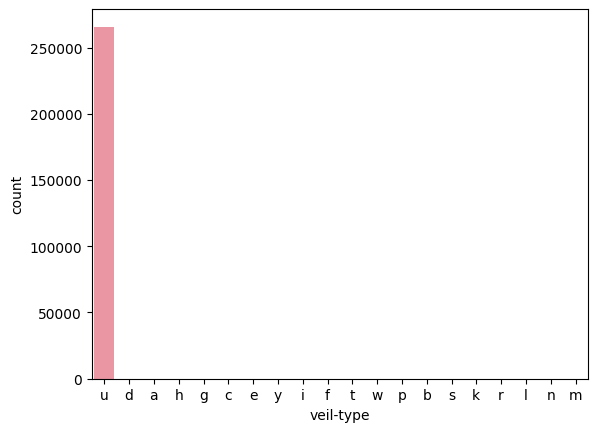

            veil-color     Ratio
veil-color                      
w               465502  8.960734
y                51255  0.986639
n                50295  0.968159
u                23439  0.451192
k                21786  0.419372
e                15316  0.294827
g                   50  0.000962
p                   41  0.000789
r                   22  0.000423
o                   18  0.000346
s                   17  0.000327
t                   16  0.000308
d                   15  0.000289
h                   12  0.000231
a                   11  0.000212
i                   10  0.000192
f                    8  0.000154
b                    7  0.000135
l                    6  0.000115
c                    5  0.000096
z                    1  0.000019
m                    1  0.000019
##########################################


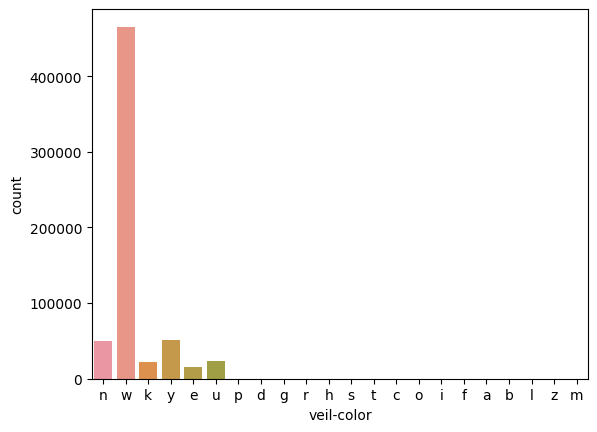

          has-ring      Ratio
has-ring                     
f          3946912  75.976538
t          1247741  24.018534
r               27   0.000520
h               21   0.000404
c               20   0.000385
e               20   0.000385
g               17   0.000327
l               16   0.000308
p               16   0.000308
s               15   0.000289
z                9   0.000173
d                8   0.000154
x                8   0.000154
m                6   0.000115
y                5   0.000096
a                5   0.000096
o                4   0.000077
k                3   0.000058
i                3   0.000058
n                2   0.000038
w                2   0.000038
b                2   0.000038
u                1   0.000019
##########################################


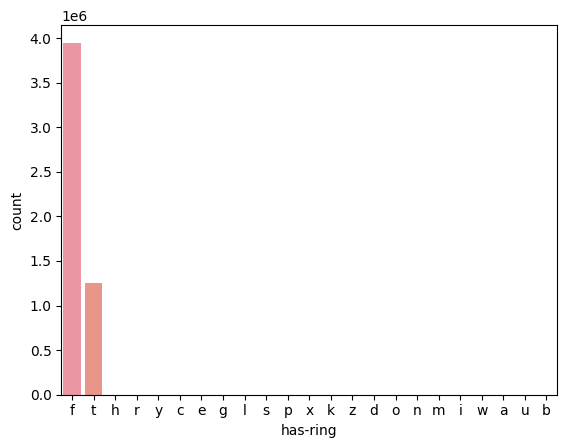

           ring-type      Ratio
ring-type                      
f            4127370  79.450285
e             200354   3.856737
z             189697   3.651594
l             122290   2.354035
p             113332   2.181597
r             113309   2.181155
g             106159   2.043520
m               6681   0.128607
t                144   0.002772
d                 61   0.001174
x                 53   0.001020
n                 50   0.000962
y                 41   0.000789
b                 41   0.000789
w                 31   0.000597
s                 30   0.000577
a                 29   0.000558
u                 27   0.000520
c                 24   0.000462
k                 22   0.000423
h                 20   0.000385
o                 18   0.000346
i                  8   0.000154
##########################################


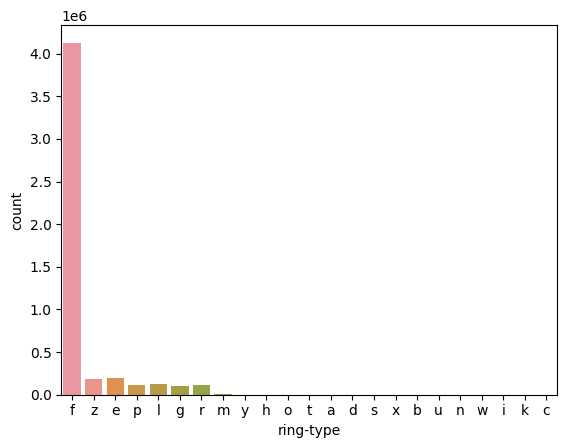

                   spore-print-color     Ratio
spore-print-color                             
k                             178883  3.443429
p                             113689  2.188470
w                              83830  1.613695
n                              37727  0.726230
r                              13280  0.255635
u                              12101  0.232940
g                               5815  0.111937
y                                 54  0.001039
s                                 31  0.000597
f                                 25  0.000481
e                                 23  0.000443
a                                 19  0.000366
c                                 19  0.000366
t                                 18  0.000346
d                                 15  0.000289
l                                 13  0.000250
b                                 12  0.000231
o                                 11  0.000212
h                                  6  0.000115
i            

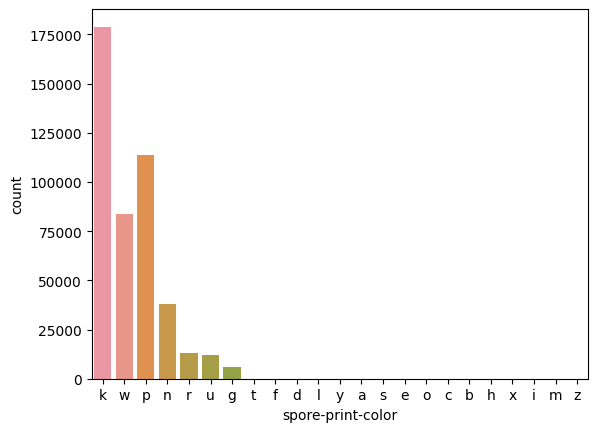

         habitat      Ratio
habitat                    
d        3627993  69.837470
g         759208  14.614462
l         286350   5.512127
m         252227   4.855273
h         200169   3.853176
w          30854   0.593928
p          28609   0.550712
u           8698   0.167433
s             91   0.001752
e             79   0.001521
t             75   0.001444
n             70   0.001347
r             59   0.001136
a             51   0.000982
k             50   0.000962
y             44   0.000847
c             44   0.000847
b             29   0.000558
f             20   0.000385
o             19   0.000366
x             13   0.000250
i             12   0.000231
z              6   0.000115
##########################################


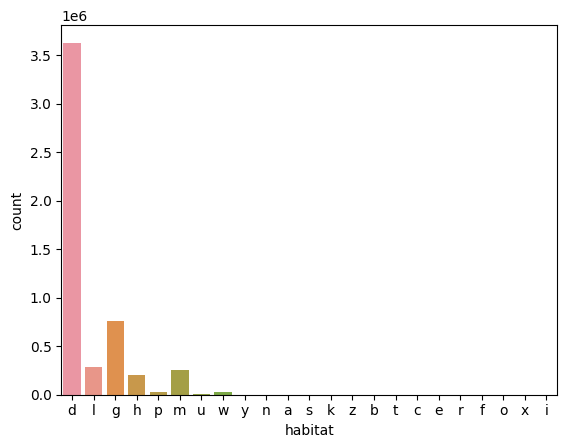

         season      Ratio
season                    
a       2572406  49.517826
u       1921855  36.994969
w        464164   8.934978
s        236484   4.552226
##########################################


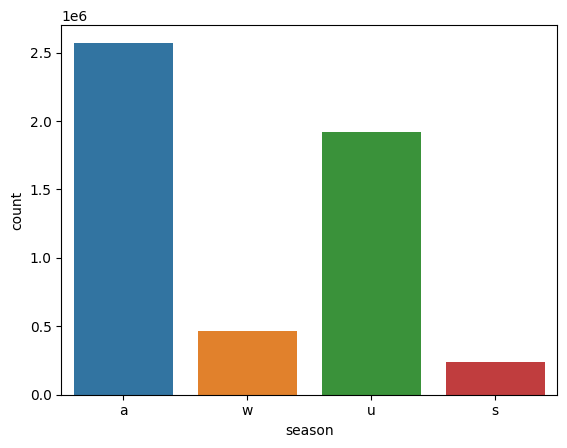

In [20]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),"Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)
            
for col in cat_cols:
    cat_summary(df, col, True)

In [21]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

for col in cat_cols:
    target_summary_with_cat(df, "class", col)

           TARGET_MEAN
cap-shape             
a             0.500000
b             0.773037
c             0.542777
d             0.600000
e             0.350000
f             0.511944
g             0.558824
h             0.500000
i             0.785714
k             0.769231
l             0.238095
m             0.500000
n             0.512195
o             0.674810
p             0.459403
r             0.656250
s             0.549457
t             0.722222
u             0.592593
w             0.500000
x             0.510166
y             0.636364
z             1.000000


             TARGET_MEAN
cap-surface             
a               0.681818
b               0.388889
c               0.645161
d               0.587883
e               0.478432
f               0.613333
g               0.597185
h               0.470129
i               0.821915
k               0.901556
l               0.428810
m               0.428571
n               0.562500
o               0.794872
p               0.72881

* Small TARGET_MEAN: Mushrooms in this category are generally edible.
* Large TARGET_MEAN: Mushrooms in this category are generally poisonous.

* Cap Shape
* z: TARGET_MEAN = 1.0 → Poisonous
* l: TARGET_MEAN = 0.238 → Edible

* Cap Surface
* r: TARGET_MEAN = 0.914 → Poisonous
* s: TARGET_MEAN = 0.369 → Edible

* Cap Color
* r: TARGET_MEAN = 0.907 → Poisonous
* b: TARGET_MEAN = 0.126 → Edible


* Does Bruise or Bleed
* a: TARGET_MEAN = 0.857 → Poisonous
* g: TARGET_MEAN = 0.000 → Edibl

* Gill Attachment
* n: TARGET_MEAN = 0.8 → Poisonous
* l: TARGET_MEAN = 0.313 → Edible

* Gill Spacing
* i, k: TARGET_MEAN = 1.000 → Poisonous
* w: TARGET_MEAN = 0.000 → Edible

* Gill Color
* z: TARGET_MEAN = 0.938 → Poisonous
* b: TARGET_MEAN = 0.282 → Edible

* Stem Root
* f, c: TARGET_MEAN = 0.988, 0.996 → Poisonous
* b: TARGET_MEAN = 0.352 → Edible

**Summary: Mushrooms with a high TARGET_MEAN are typically poisonous, while those with a low TARGET_MEAN are usually edible.**

# Analysis of numerical variables : 


In [22]:
def num_summary(dataframe,numerical_col,plot=False) :
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)
    if plot :
        dataframe[numerical_col].hist()
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

count    5.194898e+06
mean     6.308386e+00
std      4.668963e+00
min      0.000000e+00
5%       1.340000e+00
10%      1.690000e+00
20%      2.980000e+00
30%      3.650000e+00
40%      4.490000e+00
50%      5.740000e+00
60%      6.720000e+00
70%      7.690000e+00
80%      8.910000e+00
90%      1.100000e+01
95%      1.323000e+01
99%      1.889000e+01
max      6.070000e+02
Name: cap-diameter, dtype: float64


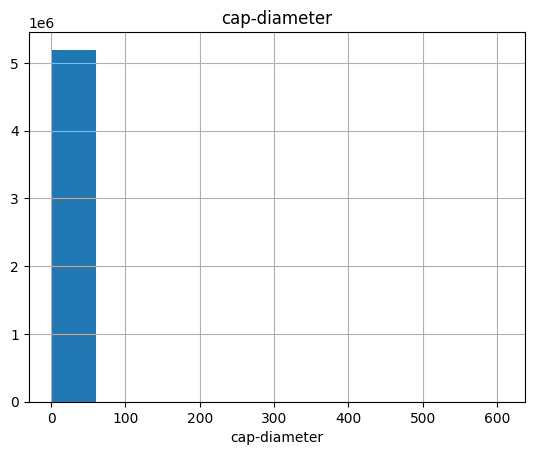

count    5.194908e+06
mean     6.347604e+00
std      2.699444e+00
min      0.000000e+00
5%       3.160000e+00
10%      3.610000e+00
20%      4.400000e+00
30%      4.910000e+00
40%      5.380000e+00
50%      5.880000e+00
60%      6.300000e+00
70%      7.020000e+00
80%      7.960000e+00
90%      9.590000e+00
95%      1.120000e+01
99%      1.666000e+01
max      8.872000e+01
Name: stem-height, dtype: float64


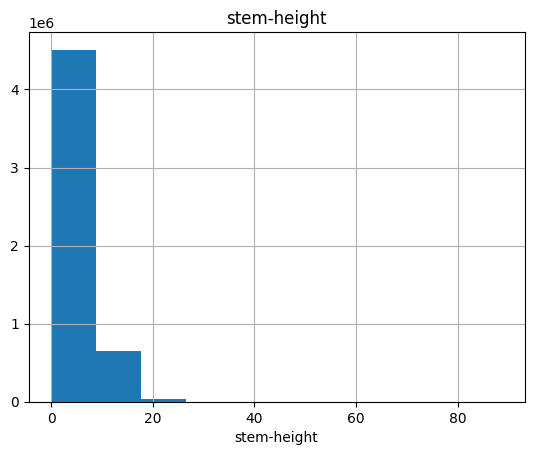

count    5.194909e+06
mean     1.115162e+01
std      8.097359e+00
min      0.000000e+00
5%       1.580000e+00
10%      2.470000e+00
20%      3.590000e+00
30%      5.910000e+00
40%      7.210000e+00
50%      9.650000e+00
60%      1.217000e+01
70%      1.415000e+01
80%      1.712000e+01
90%      2.249000e+01
95%      2.649000e+01
99%      3.546000e+01
max      1.029100e+02
Name: stem-width, dtype: float64


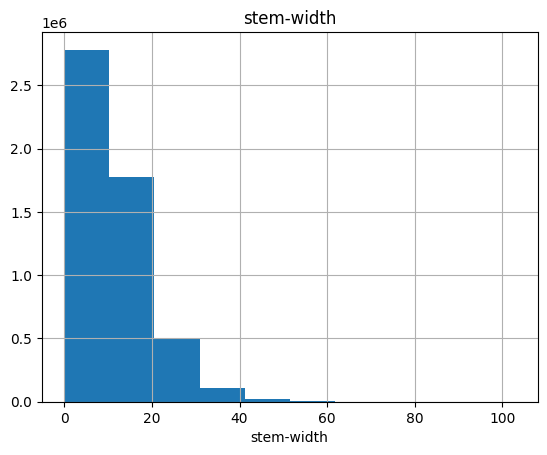

In [23]:
for col in num_cols :
    num_summary(df,col,plot=True)

In [24]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in num_cols:
    target_summary_with_num(df, "class", col)

       cap-diameter
class              
0.0        7.142471
1.0        5.620689


       stem-height
class             
0.0       6.495937
1.0       6.226162


       stem-width
class            
0.0     12.664778
1.0      9.903143




-These observations suggest that, on average, edible mushrooms have larger cap diameters and wider stems, while stem height remains relatively consistent between the two groups.

# Outliers : 

In [25]:
def outlier_thresholds(dataframe, col_name, q1=0.01, q3=0.99):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [26]:
for col in num_cols:
    print(col, check_outlier(df, col))

cap-diameter True
stem-height True
stem-width True


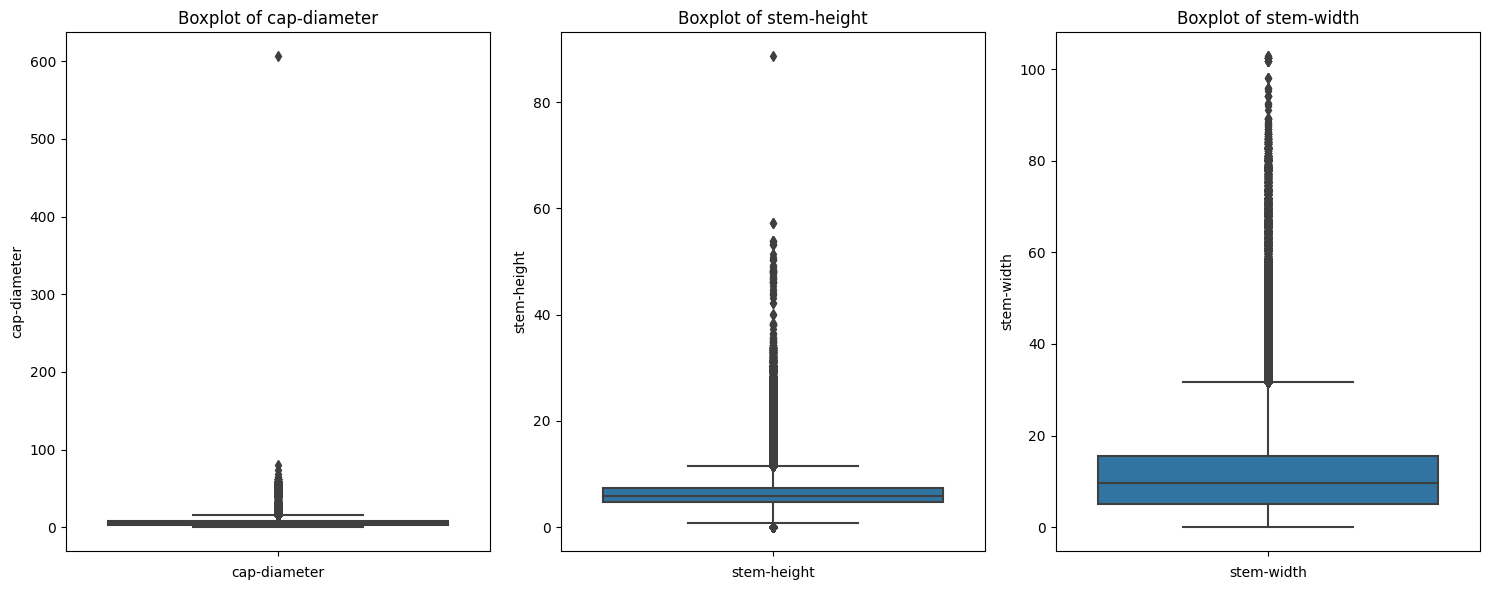

In [27]:
plt.figure(figsize=(len(num_cols) * 5, 6))  

for i, col in enumerate(num_cols):
    plt.subplot(1, len(num_cols), i + 1)  
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)

plt.tight_layout() 
plt.show()


These variables have a few very high values, let's replace the values below the 0.01 quantile with the threshold values determined for these variables.

In [28]:
for col in num_cols:
    replace_with_thresholds(df, col)

for col in num_cols:
    print(col, check_outlier(df, col))

cap-diameter False
stem-height False
stem-width False


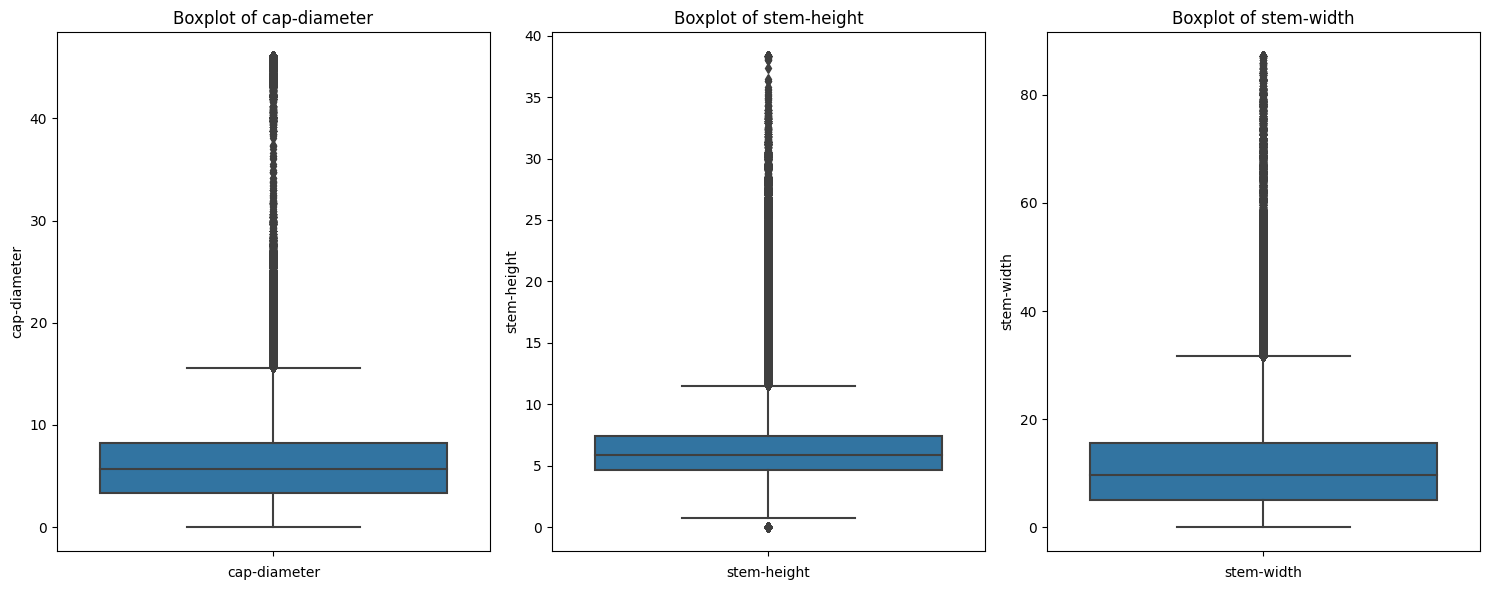

In [29]:
plt.figure(figsize=(len(num_cols) * 5, 6))  

for i, col in enumerate(num_cols):
    plt.subplot(1, len(num_cols), i + 1)  
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)

plt.tight_layout() 
plt.show()

#  Missing values : 

In [30]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns


missing_values_table(df)

                       n_miss  ratio
veil-type             4929042  94.88
spore-print-color     4749321  91.42
stem-root             4595058  88.45
veil-color            4567076  87.91
stem-surface          3302436  63.57
gill-spacing          2098079  40.39
class                 2077964  40.00
cap-surface           1118041  21.52
gill-attachment        873863  16.82
ring-type              215118   4.14
gill-color                217   0.00
cap-shape                 166   0.00
habitat                   139   0.00
cap-color                 139   0.00
stem-color                133   0.00
has-ring                   46   0.00
does-bruise-or-bleed       24   0.00
cap-diameter               11   0.00
stem-height                 1   0.00


* Upon examining the missing value table, we see that variables such as `veil-type`, `spore-print-color`, `stem-root`, and `veil-color` have very high missing value ratios.
* Variables with missing ratios greater than 80% should be dropped directly.

In [31]:
columns_to_drop = ['veil-type', 'spore-print-color', 'stem-root', 'veil-color']
df = df.drop(columns=columns_to_drop)

In [32]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
cat_cols = [col for col in cat_cols if col not in ["class",'dataset']]
num_cols = [col for col in num_cols if col not in ["id"]]
print(cat_cols)

Observations: 5194909
Variables: 19
cat_cols: 14
num_cols: 4
cat_but_car: 0
num_but_cat: 1
['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-surface', 'stem-color', 'has-ring', 'ring-type', 'habitat', 'season']


* After, columns with missing value ratios below 80% are handled.
* Missing values in numerical columns are imputed using the median value.
* For categorical columns, missing values are filled with the most frequent value (mode).
* These steps make the dataset more meaningful and suitable for analysis.

In [33]:
def fill_missing_values(df, num_cols, cat_cols):
    filled_df = df.copy()
    numeric_imputer = SimpleImputer(strategy='median')
    filled_df[num_cols] = numeric_imputer.fit_transform(filled_df[num_cols])
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    filled_df[cat_cols] = categorical_imputer.fit_transform(filled_df[cat_cols])

    return filled_df

In [34]:
df = fill_missing_values (df, num_cols, cat_cols)

# Encoding : 


* While one-hot encoding is often preferred for its effectiveness in handling categorical variables, it can significantly increase the dimensionality of the dataset, making it cumbersome to process and analyze.
* To address this, we will first perform rare encoding to reduce the number of unique classes in each categorical variable. If the frequency of a class is less than 1%, we'll label it as 'Rare.'
* After rare encoding, we will use label encoding or one-hot encoding based on the number of unique classes. If the number of unique classes is manageable, we'll use one-hot encoding; otherwise, we'll use label encoding to keep the dataset size efficient.

In [35]:
def target_summary_with_cat(dataframe,target,categorical_col) :
    target_mean=dataframe.groupby(categorical_col)[target].mean()
    category_ratio=dataframe[categorical_col].value_counts(normalize=True)
    summary_df=pd.DataFrame({'Target_mean':target_mean , 'category_ratio' : category_ratio})
    summary_df.sort_values(by='category_ratio', ascending=False)
    return summary_df
for col in cat_cols :
    summary_df=target_summary_with_cat(df,"class",col)
    print(f"Summary for {col}:\n", summary_df, "\n\n")
    

Summary for cap-shape:
            Target_mean  category_ratio
cap-shape                             
a             0.500000        0.000010
b             0.773037        0.102124
c             0.542777        0.033486
d             0.600000        0.000018
e             0.350000        0.000018
f             0.511944        0.217251
g             0.558824        0.000010
h             0.500000        0.000002
i             0.785714        0.000003
k             0.769231        0.000006
l             0.238095        0.000007
m             0.500000        0.000001
n             0.512195        0.000013
o             0.674810        0.034805
p             0.459403        0.034316
r             0.656250        0.000009
s             0.549457        0.117008
t             0.722222        0.000012
u             0.592593        0.000009
w             0.500000        0.000012
x             0.510165        0.460863
y             0.636364        0.000011
z             1.000000        0.000006 


# Rare encoding : 


In [36]:
def rare_encoder(dataframe,rare_perc) : 
    temp_df=dataframe.copy() 
    
    rare_columns=[col for col in temp_df.columns if temp_df[col].dtypes=='O' and 
                  ( temp_df[col].value_counts()/len(temp_df) < rare_perc ).any(axis=None)]
    for var in rare_columns :
        tmp=temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var]=np.where(temp_df[var].isin(rare_labels),'Rare',temp_df[var])
    return temp_df
df= rare_encoder(df,0.01)

In [37]:
df.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-surface,stem-color,has-ring,ring-type,habitat,season,dataset
0,0,0.0,8.80,f,s,u,f,a,c,w,4.51,15.39,s,w,f,f,d,a,train
1,1,1.0,4.51,x,h,o,f,a,c,n,4.79,6.48,y,o,t,z,d,w,train
2,2,0.0,6.94,f,s,b,f,x,c,w,6.85,9.93,s,n,f,f,l,w,train
3,3,0.0,3.88,f,y,g,f,s,c,g,4.16,6.53,s,w,f,f,d,u,train
4,4,0.0,5.85,x,l,w,f,d,c,w,3.37,8.36,s,w,f,f,g,a,train


In [38]:
df[cat_cols].nunique()

cap-shape                8
cap-surface             12
cap-color               13
does-bruise-or-bleed     3
gill-attachment          8
gill-spacing             4
gill-color              13
stem-surface             7
stem-color              10
has-ring                 3
ring-type                8
habitat                  6
season                   4
dtype: int64

* As can be seen, a significant reduction in the number of classes for variables with a data type of object has been observed.

* To avoid prolonging the model training time, we have set the threshold value to 5.
* For categorical variables with fewer than 5 unique classes, we will use one-hot encoding.
* For categorical variables with 5 or more unique classes, we will use label encoding.

In [39]:
unique_counts=df[cat_cols].nunique()
cat_cols_ohe=[col for col in cat_cols if unique_counts[col]<5]
cat_cols_le=[col for col in cat_cols if unique_counts[col]>=5]

# Label Encoding : 

In [40]:
cat_cols_le

['cap-shape',
 'cap-surface',
 'cap-color',
 'gill-attachment',
 'gill-color',
 'stem-surface',
 'stem-color',
 'ring-type',
 'habitat']

In [41]:
label_encoders = {}
for col in cat_cols_le:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# One Hot Encoding : 

In [42]:
cat_cols_ohe

['does-bruise-or-bleed', 'gill-spacing', 'has-ring', 'season']

In [43]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [44]:
df = one_hot_encoder(df, cat_cols_ohe)

In [45]:
df

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,gill-attachment,gill-color,stem-height,stem-width,stem-surface,stem-color,ring-type,habitat,dataset,does-bruise-or-bleed_f,does-bruise-or-bleed_t,gill-spacing_c,gill-spacing_d,gill-spacing_f,has-ring_f,has-ring_t,season_s,season_u,season_w
0,0,0.0,8.80,3,8,10,1,11,4.51,15.39,4,8,2,1,train,True,False,True,False,False,True,False,False,False,False
1,1,1.0,4.51,7,4,7,1,6,4.79,6.48,6,5,7,1,train,True,False,True,False,False,False,True,False,False,True
2,2,0.0,6.94,3,8,1,7,11,6.85,9.93,4,4,2,4,train,True,False,True,False,False,True,False,False,False,True
3,3,0.0,3.88,3,11,3,6,4,4.16,6.53,4,8,2,1,train,True,False,True,False,False,True,False,False,True,False
4,4,0.0,5.85,7,7,11,2,11,3.37,8.36,4,8,2,2,train,True,False,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077959,5194904,NaN,0.88,7,3,11,1,11,2.67,1.35,4,1,2,1,test,True,False,False,True,False,True,False,False,True,False
2077960,5194905,NaN,3.12,7,8,11,2,11,2.69,7.38,4,8,2,2,test,True,False,True,False,False,True,False,False,False,False
2077961,5194906,NaN,5.73,7,2,2,1,11,6.16,9.74,4,9,7,1,test,True,False,True,False,False,False,True,False,False,False
2077962,5194907,NaN,5.03,1,3,6,1,4,6.00,3.46,4,2,2,1,test,True,False,False,True,False,True,False,False,False,False


In [46]:
train_processed = df[df['dataset'] == 'train'].drop(columns=['dataset'])
test_processed = df[df['dataset'] == 'test'].drop(columns=['dataset'])



X = train_processed.drop(columns=['class'])
y = train_processed['class'] 


test_processed=test_processed.drop(columns=['class'])
test_processed



,id,cap-diameter,cap-shape,cap-surface,cap-color,gill-attachment,gill-color,stem-height,stem-width,stem-surface,stem-color,ring-type,habitat,does-bruise-or-bleed_f,does-bruise-or-bleed_t,gill-spacing_c,gill-spacing_d,gill-spacing_f,has-ring_f,has-ring_t,season_s,season_u,season_w
0,3116945,8.64,7,9,6,1,11,11.13,17.12,4,8,3,1,False,True,True,False,False,False,True,False,False,False
1,3116946,6.90,4,9,7,1,12,1.27,10.75,4,4,2,1,True,False,True,False,False,True,False,False,False,False
2,3116947,2.00,1,3,6,1,6,6.18,3.14,4,4,2,1,True,False,True,False,False,True,False,True,False,False
3,3116948,3.47,7,9,6,6,6,4.98,8.51,4,8,7,1,True,False,True,False,False,False,True,False,True,False
4,3116949,6.17,7,4,12,5,12,6.73,13.70,4,9,2,1,True,False,True,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077959,5194904,0.88,7,3,11,1,11,2.67,1.35,4,1,2,1,True,False,False,True,False,True,False,False,True,False
2077960,5194905,3.12,7,8,11,2,11,2.69,7.38,4,8,2,2,True,False,True,False,False,True,False,False,False,False
2077961,5194906,5.73,7,2,2,1,11,6.16,9.74,4,9,7,1,True,False,True,False,False,False,True,False,False,False
2077962,5194907,5.03,1,3,6,1,4,6.00,3.46,4,2,2,1,True,False,False,True,False,True,False,False,False,False


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
 # Define the objective function for Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),    
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 10.0),
        'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1.0, 10.0)
     }
    
    model = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mcc = matthews_corrcoef(y_test, y_pred)
    trial.set_user_attr("mcc", mcc)
    return mcc

 # Callback to print the MCC score for each trial
def print_mcc_callback(study, trial):
    mcc = trial.user_attrs["mcc"]
    print(f"Trial {trial.number}: MCC = {mcc}")

 # Optimize hyperparameters with Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, callbacks=[print_mcc_callback])

 # Get the best parameters
best_params = study.best_params
print(f"Best parameters: {best_params}")

 # Train final model with best hyperparameters
final_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
final_model.fit(X_train, y_train)

 # Predict and evaluate the final model
y_pred = final_model.predict(X_test)
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient: {mcc}")
 

[I 2024-08-14 22:07:34,046] A new study created in memory with name: no-name-6134c9f7-e347-45c3-a019-f5990ba1b882
[I 2024-08-14 22:09:17,583] Trial 0 finished with value: 0.9757349012996407 and parameters: {'n_estimators': 253, 'max_depth': 12, 'learning_rate': 0.02006424218525026, 'subsample': 0.9673281690117768, 'colsample_bytree': 0.828397493774983, 'gamma': 0.0001670999353747206, 'lambda': 0.0008188406655240406, 'alpha': 1.3733069615298498e-05, 'scale_pos_weight': 5.962427235751627}. Best is trial 0 with value: 0.9757349012996407.


Trial 0: MCC = 0.9757349012996407


[I 2024-08-14 22:14:16,313] Trial 1 finished with value: 0.9809494549463513 and parameters: {'n_estimators': 844, 'max_depth': 12, 'learning_rate': 0.08105335976157049, 'subsample': 0.7189940508015096, 'colsample_bytree': 0.7024432892909608, 'gamma': 0.002395061012635881, 'lambda': 0.45518801863513647, 'alpha': 0.5348808325636357, 'scale_pos_weight': 6.546777420567451}. Best is trial 1 with value: 0.9809494549463513.


Trial 1: MCC = 0.9809494549463513


[I 2024-08-14 22:20:54,750] Trial 2 finished with value: 0.9815937251624902 and parameters: {'n_estimators': 924, 'max_depth': 16, 'learning_rate': 0.14272176046280768, 'subsample': 0.7628470489232362, 'colsample_bytree': 0.6839004101373539, 'gamma': 5.556680861116033e-06, 'lambda': 0.001186227110713569, 'alpha': 1.7512604648878688e-07, 'scale_pos_weight': 5.754156257386527}. Best is trial 2 with value: 0.9815937251624902.


Trial 2: MCC = 0.9815937251624902


[I 2024-08-14 22:22:41,686] Trial 3 finished with value: 0.9787882007995442 and parameters: {'n_estimators': 139, 'max_depth': 18, 'learning_rate': 0.023845192812703888, 'subsample': 0.5079726010142354, 'colsample_bytree': 0.6335232659620988, 'gamma': 0.002126388901592622, 'lambda': 4.2014232229007713e-07, 'alpha': 5.456609285120419e-08, 'scale_pos_weight': 7.137806447950997}. Best is trial 2 with value: 0.9815937251624902.


Trial 3: MCC = 0.9787882007995442


[I 2024-08-14 22:25:37,777] Trial 4 finished with value: 0.9673916970783323 and parameters: {'n_estimators': 629, 'max_depth': 9, 'learning_rate': 0.011204599875547274, 'subsample': 0.7689087410151245, 'colsample_bytree': 0.7690118877691978, 'gamma': 5.7181443984356595e-08, 'lambda': 0.4014845660970953, 'alpha': 1.0946546596545344e-06, 'scale_pos_weight': 7.490986912065037}. Best is trial 2 with value: 0.9815937251624902.


Trial 4: MCC = 0.9673916970783323


[I 2024-08-14 22:27:40,060] Trial 5 finished with value: 0.9784146156576012 and parameters: {'n_estimators': 358, 'max_depth': 11, 'learning_rate': 0.11572861795614145, 'subsample': 0.7635613249987212, 'colsample_bytree': 0.7851643495408991, 'gamma': 6.982387924834949e-08, 'lambda': 1.7013098717235192e-07, 'alpha': 0.04764021242777551, 'scale_pos_weight': 9.773477330645425}. Best is trial 2 with value: 0.9815937251624902.


Trial 5: MCC = 0.9784146156576012


[I 2024-08-14 22:33:58,744] Trial 6 finished with value: 0.9813803582221443 and parameters: {'n_estimators': 784, 'max_depth': 20, 'learning_rate': 0.19490430075653004, 'subsample': 0.8108610080851176, 'colsample_bytree': 0.8561745700091797, 'gamma': 8.890745510140525e-06, 'lambda': 0.00569839424113816, 'alpha': 0.001307210664635005, 'scale_pos_weight': 2.159000660697435}. Best is trial 2 with value: 0.9815937251624902.


Trial 6: MCC = 0.9813803582221443


[I 2024-08-14 22:38:08,329] Trial 7 finished with value: 0.9795898781550507 and parameters: {'n_estimators': 928, 'max_depth': 9, 'learning_rate': 0.20734781010804892, 'subsample': 0.6203104836918025, 'colsample_bytree': 0.5953688949779381, 'gamma': 0.0037266253278823635, 'lambda': 0.169414565638685, 'alpha': 2.218436219555357e-05, 'scale_pos_weight': 5.122549805380938}. Best is trial 2 with value: 0.9815937251624902.


Trial 7: MCC = 0.9795898781550507


[I 2024-08-14 22:41:48,096] Trial 8 finished with value: 0.981984911927246 and parameters: {'n_estimators': 591, 'max_depth': 14, 'learning_rate': 0.19105551620483738, 'subsample': 0.9884674959610732, 'colsample_bytree': 0.5041518611663414, 'gamma': 0.0037050675756933366, 'lambda': 1.5856464978407686e-06, 'alpha': 1.1495922690428046e-08, 'scale_pos_weight': 1.7667733994389636}. Best is trial 8 with value: 0.981984911927246.


Trial 8: MCC = 0.981984911927246


[I 2024-08-14 22:42:26,718] Trial 9 finished with value: 0.9030271951937858 and parameters: {'n_estimators': 120, 'max_depth': 7, 'learning_rate': 0.032551106096765564, 'subsample': 0.5635954463265995, 'colsample_bytree': 0.5694080146396383, 'gamma': 0.004902574786182056, 'lambda': 0.12030815850186805, 'alpha': 0.04740666578668851, 'scale_pos_weight': 4.207742720836167}. Best is trial 8 with value: 0.981984911927246.


Trial 9: MCC = 0.9030271951937858


[I 2024-08-14 22:43:37,763] Trial 10 finished with value: 0.9396894988040092 and parameters: {'n_estimators': 487, 'max_depth': 3, 'learning_rate': 0.06412898246597648, 'subsample': 0.9687946993767437, 'colsample_bytree': 0.9737828970635368, 'gamma': 0.4173841166043693, 'lambda': 8.557470943086994e-06, 'alpha': 0.00020241455073299988, 'scale_pos_weight': 1.0162666607682707}. Best is trial 8 with value: 0.981984911927246.


Trial 10: MCC = 0.9396894988040092


[I 2024-08-14 22:48:20,770] Trial 11 finished with value: 0.9811911669856426 and parameters: {'n_estimators': 675, 'max_depth': 16, 'learning_rate': 0.28807891001204905, 'subsample': 0.8741390035566874, 'colsample_bytree': 0.5076552586375255, 'gamma': 3.5090353280179618e-06, 'lambda': 1.4464158961077664e-05, 'alpha': 1.3572348892667516e-08, 'scale_pos_weight': 3.218095888017597}. Best is trial 8 with value: 0.981984911927246.


Trial 11: MCC = 0.9811911669856426


[I 2024-08-14 22:53:43,784] Trial 12 finished with value: 0.9810661160881077 and parameters: {'n_estimators': 991, 'max_depth': 15, 'learning_rate': 0.1380378074437249, 'subsample': 0.6622640865896561, 'colsample_bytree': 0.6756625156566196, 'gamma': 0.21692057216704957, 'lambda': 2.9592293837426596e-05, 'alpha': 2.2919046768689692e-07, 'scale_pos_weight': 8.893763639160774}. Best is trial 8 with value: 0.981984911927246.


Trial 12: MCC = 0.9810661160881077


[I 2024-08-14 22:57:16,158] Trial 13 finished with value: 0.9819429316103652 and parameters: {'n_estimators': 492, 'max_depth': 15, 'learning_rate': 0.11100936525321489, 'subsample': 0.8803610182285307, 'colsample_bytree': 0.5647239179203523, 'gamma': 4.281527428108076e-06, 'lambda': 3.094691845672262e-08, 'alpha': 9.522033149386473e-07, 'scale_pos_weight': 4.348200162225906}. Best is trial 8 with value: 0.981984911927246.


Trial 13: MCC = 0.9819429316103652


[I 2024-08-14 23:00:23,982] Trial 14 finished with value: 0.9820877744631035 and parameters: {'n_estimators': 456, 'max_depth': 14, 'learning_rate': 0.08629338349859061, 'subsample': 0.9090063723374074, 'colsample_bytree': 0.5020645719347312, 'gamma': 4.02505167735507e-05, 'lambda': 1.1031605109873859e-08, 'alpha': 1.3962695232061523e-06, 'scale_pos_weight': 3.0693204898771906}. Best is trial 14 with value: 0.9820877744631035.


Trial 14: MCC = 0.9820877744631035


[I 2024-08-14 23:03:18,365] Trial 15 finished with value: 0.9821993456051513 and parameters: {'n_estimators': 420, 'max_depth': 13, 'learning_rate': 0.039342552224456206, 'subsample': 0.9182322741548805, 'colsample_bytree': 0.5052819823728911, 'gamma': 0.0001726239181379506, 'lambda': 5.621235788297754e-07, 'alpha': 1.1413594955326588e-08, 'scale_pos_weight': 2.4127128156921973}. Best is trial 15 with value: 0.9821993456051513.


Trial 15: MCC = 0.9821993456051513


[I 2024-08-14 23:04:29,180] Trial 16 finished with value: 0.9575262438510267 and parameters: {'n_estimators': 356, 'max_depth': 5, 'learning_rate': 0.04030726445583667, 'subsample': 0.8982890709736082, 'colsample_bytree': 0.5115166665452371, 'gamma': 0.0001555454431886139, 'lambda': 1.2184191254058867e-08, 'alpha': 6.204750499443108e-06, 'scale_pos_weight': 2.954721009046253}. Best is trial 15 with value: 0.9821993456051513.


Trial 16: MCC = 0.9575262438510267


[I 2024-08-14 23:08:28,586] Trial 17 finished with value: 0.9824054294856059 and parameters: {'n_estimators': 387, 'max_depth': 18, 'learning_rate': 0.04945140122067531, 'subsample': 0.8364524723748488, 'colsample_bytree': 0.6212353118551224, 'gamma': 3.2425260167496013e-07, 'lambda': 1.4278077652633605e-07, 'alpha': 0.0003195696278837985, 'scale_pos_weight': 3.317245896734082}. Best is trial 17 with value: 0.9824054294856059.


Trial 17: MCC = 0.9824054294856059


[I 2024-08-14 23:12:29,086] Trial 18 finished with value: 0.9824915189758974 and parameters: {'n_estimators': 324, 'max_depth': 20, 'learning_rate': 0.04649584745659693, 'subsample': 0.8168372352170621, 'colsample_bytree': 0.6252130631545184, 'gamma': 3.582050291630521e-07, 'lambda': 6.09545588739845e-05, 'alpha': 0.0021155571938731013, 'scale_pos_weight': 4.113111185444595}. Best is trial 18 with value: 0.9824915189758974.


Trial 18: MCC = 0.9824915189758974


[I 2024-08-14 23:15:05,254] Trial 19 finished with value: 0.9815344638840227 and parameters: {'n_estimators': 254, 'max_depth': 20, 'learning_rate': 0.052271142402002244, 'subsample': 0.8488481438172054, 'colsample_bytree': 0.6316947055572367, 'gamma': 1.001833562692656e-08, 'lambda': 6.267649387498303, 'alpha': 0.0023413700726991732, 'scale_pos_weight': 4.234021862197827}. Best is trial 18 with value: 0.9824915189758974.


Trial 19: MCC = 0.9815344638840227


[I 2024-08-14 23:18:21,936] Trial 20 finished with value: 0.9808750551144256 and parameters: {'n_estimators': 253, 'max_depth': 18, 'learning_rate': 0.015554782233921097, 'subsample': 0.7017849749812093, 'colsample_bytree': 0.7254322213305575, 'gamma': 2.3642772682190555e-07, 'lambda': 0.00010921554072902657, 'alpha': 0.00024522440457094174, 'scale_pos_weight': 4.895627789570351}. Best is trial 18 with value: 0.9824915189758974.


Trial 20: MCC = 0.9808750551144256


[I 2024-08-14 23:22:33,636] Trial 21 finished with value: 0.9823553408712276 and parameters: {'n_estimators': 385, 'max_depth': 18, 'learning_rate': 0.03655619002807394, 'subsample': 0.8212289276721256, 'colsample_bytree': 0.6173033140887512, 'gamma': 4.830978202739042e-07, 'lambda': 8.947681374913956e-07, 'alpha': 0.006425476570938015, 'scale_pos_weight': 3.48955086156461}. Best is trial 18 with value: 0.9824915189758974.


Trial 21: MCC = 0.9823553408712276


[I 2024-08-14 23:26:39,356] Trial 22 finished with value: 0.9822902387869845 and parameters: {'n_estimators': 329, 'max_depth': 19, 'learning_rate': 0.027720560767063595, 'subsample': 0.8193914018453029, 'colsample_bytree': 0.6362660739927916, 'gamma': 7.275992836540348e-07, 'lambda': 3.7044293705865484e-06, 'alpha': 0.01016511581711254, 'scale_pos_weight': 3.5562852896918393}. Best is trial 18 with value: 0.9824915189758974.


Trial 22: MCC = 0.9822902387869845


[I 2024-08-14 23:31:14,661] Trial 23 finished with value: 0.9818690280329383 and parameters: {'n_estimators': 543, 'max_depth': 17, 'learning_rate': 0.05327251320840551, 'subsample': 0.8193980799953762, 'colsample_bytree': 0.5921349460215877, 'gamma': 5.912958106853634e-07, 'lambda': 1.0849822777054626e-07, 'alpha': 2.558392519251105, 'scale_pos_weight': 3.9731817156159335}. Best is trial 18 with value: 0.9824915189758974.


Trial 23: MCC = 0.9818690280329383


[I 2024-08-14 23:35:10,585] Trial 24 finished with value: 0.9826824672676117 and parameters: {'n_estimators': 387, 'max_depth': 18, 'learning_rate': 0.04152911045594938, 'subsample': 0.7949893043541244, 'colsample_bytree': 0.6562680335669864, 'gamma': 2.4920272180471637e-08, 'lambda': 9.301114697217347e-05, 'alpha': 9.704556122093213e-05, 'scale_pos_weight': 1.3944960185112625}. Best is trial 24 with value: 0.9826824672676117.


Trial 24: MCC = 0.9826824672676117


[I 2024-08-14 23:37:15,989] Trial 25 finished with value: 0.982525495274069 and parameters: {'n_estimators': 189, 'max_depth': 20, 'learning_rate': 0.06689037916437696, 'subsample': 0.7110440267317228, 'colsample_bytree': 0.7297951390042756, 'gamma': 1.7476503586375123e-08, 'lambda': 0.008382440292783956, 'alpha': 5.1558995062999646e-05, 'scale_pos_weight': 1.2283657031088087}. Best is trial 24 with value: 0.9826824672676117.


Trial 25: MCC = 0.982525495274069


[I 2024-08-14 23:39:17,983] Trial 26 finished with value: 0.9823139835121755 and parameters: {'n_estimators': 183, 'max_depth': 20, 'learning_rate': 0.07071605693912933, 'subsample': 0.7083499417349994, 'colsample_bytree': 0.8079383896744633, 'gamma': 1.1682493561566497e-08, 'lambda': 0.01993342119133184, 'alpha': 5.834706082951909e-05, 'scale_pos_weight': 1.1888399882661893}. Best is trial 24 with value: 0.9826824672676117.


Trial 26: MCC = 0.9823139835121755


[I 2024-08-14 23:42:23,599] Trial 27 finished with value: 0.9824751233322754 and parameters: {'n_estimators': 289, 'max_depth': 20, 'learning_rate': 0.09245974736966808, 'subsample': 0.7808656492434464, 'colsample_bytree': 0.7318819606325246, 'gamma': 5.208988089592673e-08, 'lambda': 0.00014990932539047175, 'alpha': 6.829846836922685e-05, 'scale_pos_weight': 1.7079912688321082}. Best is trial 24 with value: 0.9826824672676117.


Trial 27: MCC = 0.9824751233322754


[I 2024-08-14 23:44:13,975] Trial 28 finished with value: 0.9819377821607791 and parameters: {'n_estimators': 192, 'max_depth': 17, 'learning_rate': 0.06539021730543557, 'subsample': 0.6561101230973084, 'colsample_bytree': 0.9005269808949752, 'gamma': 2.6635445154700932e-08, 'lambda': 0.002109284877217059, 'alpha': 0.001249913753203762, 'scale_pos_weight': 2.0160927388935797}. Best is trial 24 with value: 0.9826824672676117.


Trial 28: MCC = 0.9819377821607791


[I 2024-08-14 23:46:49,336] Trial 29 finished with value: 0.9819985200750496 and parameters: {'n_estimators': 186, 'max_depth': 19, 'learning_rate': 0.020312572124381496, 'subsample': 0.7294384907477313, 'colsample_bytree': 0.6671958418324684, 'gamma': 8.685799989381969e-08, 'lambda': 0.000493309903490579, 'alpha': 7.010576906544906e-06, 'scale_pos_weight': 2.5812018126018295}. Best is trial 24 with value: 0.9826824672676117.


Trial 29: MCC = 0.9819985200750496


[I 2024-08-14 23:49:51,614] Trial 30 finished with value: 0.9822823940106918 and parameters: {'n_estimators': 288, 'max_depth': 19, 'learning_rate': 0.044692655614153726, 'subsample': 0.6777559856037232, 'colsample_bytree': 0.8518324398746046, 'gamma': 1.8178827939170276e-07, 'lambda': 0.011892695210938749, 'alpha': 0.06689190680706412, 'scale_pos_weight': 1.7078059728962813}. Best is trial 24 with value: 0.9826824672676117.


Trial 30: MCC = 0.9822823940106918


[I 2024-08-14 23:53:01,104] Trial 31 finished with value: 0.9824085110948568 and parameters: {'n_estimators': 309, 'max_depth': 20, 'learning_rate': 0.0881930029487636, 'subsample': 0.775013529649891, 'colsample_bytree': 0.7371794469058527, 'gamma': 2.411131644062575e-08, 'lambda': 0.00026782353107724033, 'alpha': 4.169115437861499e-05, 'scale_pos_weight': 1.5068169726833873}. Best is trial 24 with value: 0.9826824672676117.


Trial 31: MCC = 0.9824085110948568


[I 2024-08-14 23:54:59,301] Trial 32 finished with value: 0.9822873571405153 and parameters: {'n_estimators': 221, 'max_depth': 17, 'learning_rate': 0.10192993920573121, 'subsample': 0.7956259480023995, 'colsample_bytree': 0.7209616819366474, 'gamma': 1.5975775675367027e-06, 'lambda': 5.9296376261702076e-05, 'alpha': 0.0004969136453296216, 'scale_pos_weight': 1.0348982778319447}. Best is trial 24 with value: 0.9826824672676117.


Trial 32: MCC = 0.9822873571405153


[I 2024-08-14 23:58:25,809] Trial 33 finished with value: 0.9824399787762736 and parameters: {'n_estimators': 279, 'max_depth': 19, 'learning_rate': 0.029483128324913652, 'subsample': 0.7373614833449987, 'colsample_bytree': 0.7013047274558103, 'gamma': 6.449158739916165e-08, 'lambda': 9.553740417643248e-05, 'alpha': 0.00012121905466025333, 'scale_pos_weight': 2.430899498570072}. Best is trial 24 with value: 0.9826824672676117.


Trial 33: MCC = 0.9824399787762736


[I 2024-08-14 23:59:56,511] Trial 34 finished with value: 0.9814955117494372 and parameters: {'n_estimators': 105, 'max_depth': 20, 'learning_rate': 0.07216781488414978, 'subsample': 0.7927091176481816, 'colsample_bytree': 0.7623353066302366, 'gamma': 2.1731629495862633e-08, 'lambda': 0.0017189511692215966, 'alpha': 9.104687296754116e-06, 'scale_pos_weight': 6.213227852583598}. Best is trial 24 with value: 0.9826824672676117.


Trial 34: MCC = 0.9814955117494372


[I 2024-08-15 00:03:37,464] Trial 35 finished with value: 0.9821683662223512 and parameters: {'n_estimators': 436, 'max_depth': 16, 'learning_rate': 0.05895332657861076, 'subsample': 0.6160779149283451, 'colsample_bytree': 0.6624476255357739, 'gamma': 1.4149542315086555e-07, 'lambda': 0.00025491923444723175, 'alpha': 6.166337704198242e-05, 'scale_pos_weight': 2.598625975099559}. Best is trial 24 with value: 0.9826824672676117.


Trial 35: MCC = 0.9821683662223512


[I 2024-08-15 00:04:57,462] Trial 36 finished with value: 0.9776374966695534 and parameters: {'n_estimators': 222, 'max_depth': 11, 'learning_rate': 0.08541825004131376, 'subsample': 0.7536756530983412, 'colsample_bytree': 0.6985164758073596, 'gamma': 1.2433414773496662e-06, 'lambda': 0.045243724150189873, 'alpha': 0.008465875844710575, 'scale_pos_weight': 7.082726009616989}. Best is trial 24 with value: 0.9826824672676117.


Trial 36: MCC = 0.9776374966695534


[I 2024-08-15 00:06:35,988] Trial 37 finished with value: 0.9821316086026025 and parameters: {'n_estimators': 154, 'max_depth': 19, 'learning_rate': 0.13579038215501935, 'subsample': 0.8572935033423272, 'colsample_bytree': 0.803168346078111, 'gamma': 3.401121362997298e-08, 'lambda': 0.0010396293680503329, 'alpha': 0.0005708512978905413, 'scale_pos_weight': 1.535622092505023}. Best is trial 24 with value: 0.9826824672676117.


Trial 37: MCC = 0.9821316086026025


[I 2024-08-15 00:10:27,111] Trial 38 finished with value: 0.9814072037917618 and parameters: {'n_estimators': 326, 'max_depth': 18, 'learning_rate': 0.023575997567624674, 'subsample': 0.6926763966457694, 'colsample_bytree': 0.7464621730990655, 'gamma': 1.860974319965884e-05, 'lambda': 0.0032321621011735238, 'alpha': 3.924255890374727e-06, 'scale_pos_weight': 5.679452403164468}. Best is trial 24 with value: 0.9826824672676117.


Trial 38: MCC = 0.9814072037917618


[I 2024-08-15 00:17:22,651] Trial 39 finished with value: 0.9805158676738828 and parameters: {'n_estimators': 710, 'max_depth': 16, 'learning_rate': 0.014696950381673478, 'subsample': 0.7837832485970216, 'colsample_bytree': 0.6546023346064029, 'gamma': 6.715400554124487e-08, 'lambda': 5.251121983725633e-06, 'alpha': 2.63643217793943e-05, 'scale_pos_weight': 8.029336654603092}. Best is trial 24 with value: 0.9826824672676117.


Trial 39: MCC = 0.9805158676738828


[I 2024-08-15 00:19:59,693] Trial 40 finished with value: 0.9818303164285378 and parameters: {'n_estimators': 536, 'max_depth': 10, 'learning_rate': 0.043810832170525685, 'subsample': 0.7450163556779716, 'colsample_bytree': 0.5491010399657412, 'gamma': 0.0005198260018064698, 'lambda': 1.1982475361477742, 'alpha': 0.002314345601064655, 'scale_pos_weight': 1.9988956387157784}. Best is trial 24 with value: 0.9826824672676117.


Trial 40: MCC = 0.9818303164285378


[I 2024-08-15 00:23:34,499] Trial 41 finished with value: 0.9824877215314101 and parameters: {'n_estimators': 292, 'max_depth': 19, 'learning_rate': 0.028856352757164378, 'subsample': 0.7246784323696063, 'colsample_bytree': 0.6966864085933602, 'gamma': 5.740308511038204e-08, 'lambda': 0.0001382679400157063, 'alpha': 0.00010480065287568746, 'scale_pos_weight': 2.2117940783186802}. Best is trial 24 with value: 0.9826824672676117.


Trial 41: MCC = 0.9824877215314101


[I 2024-08-15 00:28:08,029] Trial 42 finished with value: 0.982702260522948 and parameters: {'n_estimators': 387, 'max_depth': 20, 'learning_rate': 0.03504608293592265, 'subsample': 0.7212852842977223, 'colsample_bytree': 0.6939189165896839, 'gamma': 1.0079133325455709e-08, 'lambda': 0.00017550420111521288, 'alpha': 9.407729700076011e-05, 'scale_pos_weight': 1.4272530862583679}. Best is trial 42 with value: 0.982702260522948.


Trial 42: MCC = 0.982702260522948


[I 2024-08-15 00:31:59,084] Trial 43 finished with value: 0.9826568256100612 and parameters: {'n_estimators': 400, 'max_depth': 17, 'learning_rate': 0.03331997666180471, 'subsample': 0.6177459454801638, 'colsample_bytree': 0.6909454320922634, 'gamma': 1.0955248900345683e-08, 'lambda': 1.375719830227578e-05, 'alpha': 1.772122025522453e-05, 'scale_pos_weight': 1.2724780627089205}. Best is trial 42 with value: 0.982702260522948.


Trial 43: MCC = 0.9826568256100612


[I 2024-08-15 00:35:43,705] Trial 44 finished with value: 0.9824294112768464 and parameters: {'n_estimators': 394, 'max_depth': 17, 'learning_rate': 0.03421179054119348, 'subsample': 0.5575652854966489, 'colsample_bytree': 0.7734123674062157, 'gamma': 1.0081868355955137e-08, 'lambda': 2.2961415962555537e-05, 'alpha': 1.717594626447018e-05, 'scale_pos_weight': 1.4171546685233072}. Best is trial 42 with value: 0.982702260522948.


Trial 44: MCC = 0.9824294112768464


[I 2024-08-15 00:40:56,040] Trial 45 finished with value: 0.9829255016793694 and parameters: {'n_estimators': 508, 'max_depth': 18, 'learning_rate': 0.023063934668406852, 'subsample': 0.6442810216764022, 'colsample_bytree': 0.6474561801990288, 'gamma': 0.016212549913750512, 'lambda': 2.0103789802483215e-06, 'alpha': 0.001139243491251937, 'scale_pos_weight': 1.0863394186425577}. Best is trial 45 with value: 0.9829255016793694.


Trial 45: MCC = 0.9829255016793694


[I 2024-08-15 00:45:57,087] Trial 46 finished with value: 0.9827530011125413 and parameters: {'n_estimators': 623, 'max_depth': 15, 'learning_rate': 0.018836669485993638, 'subsample': 0.623535104928297, 'colsample_bytree': 0.6844003115491649, 'gamma': 0.03401901644592456, 'lambda': 1.7029600917315625e-06, 'alpha': 3.1644404261233577e-06, 'scale_pos_weight': 1.0661532580960609}. Best is trial 45 with value: 0.9829255016793694.


Trial 46: MCC = 0.9827530011125413


[I 2024-08-15 00:51:02,098] Trial 47 finished with value: 0.9818797414665549 and parameters: {'n_estimators': 606, 'max_depth': 15, 'learning_rate': 0.015838562812190614, 'subsample': 0.6156054141424808, 'colsample_bytree': 0.6823941141131541, 'gamma': 0.05003716986892556, 'lambda': 2.453386727669406e-06, 'alpha': 2.9080751133712054e-06, 'scale_pos_weight': 2.773125564700098}. Best is trial 45 with value: 0.9829255016793694.


Trial 47: MCC = 0.9818797414665549


[I 2024-08-15 00:56:15,247] Trial 48 finished with value: 0.9821636262451736 and parameters: {'n_estimators': 659, 'max_depth': 14, 'learning_rate': 0.011094498548287954, 'subsample': 0.5840652490578073, 'colsample_bytree': 0.6498871842271398, 'gamma': 0.01872625498071065, 'lambda': 1.631930073708189e-05, 'alpha': 2.7849657386289e-07, 'scale_pos_weight': 1.8284650480034685}. Best is trial 45 with value: 0.9829255016793694.


Trial 48: MCC = 0.9821636262451736


[I 2024-08-15 00:59:39,467] Trial 49 finished with value: 0.975764046715915 and parameters: {'n_estimators': 490, 'max_depth': 13, 'learning_rate': 0.019447468600996023, 'subsample': 0.5435988339308735, 'colsample_bytree': 0.589708521353641, 'gamma': 0.91832191532133, 'lambda': 1.5403982634053456e-06, 'alpha': 7.767744866599068e-08, 'scale_pos_weight': 9.951043989127253}. Best is trial 45 with value: 0.9829255016793694.


Trial 49: MCC = 0.975764046715915


[I 2024-08-15 01:03:58,771] Trial 50 finished with value: 0.9823857947333642 and parameters: {'n_estimators': 525, 'max_depth': 15, 'learning_rate': 0.02347344646318852, 'subsample': 0.6522658037891842, 'colsample_bytree': 0.6813525508837364, 'gamma': 0.0161133919923566, 'lambda': 8.421944460578018e-06, 'alpha': 1.2828411878634292e-06, 'scale_pos_weight': 2.1164846630571383}. Best is trial 45 with value: 0.9829255016793694.


Trial 50: MCC = 0.9823857947333642


[I 2024-08-15 01:11:23,211] Trial 51 finished with value: 0.9827107887669556 and parameters: {'n_estimators': 768, 'max_depth': 18, 'learning_rate': 0.020562653500289615, 'subsample': 0.6358916536118849, 'colsample_bytree': 0.7155360263678172, 'gamma': 0.07977948098824768, 'lambda': 3.621089432888307e-05, 'alpha': 2.076744879851539e-05, 'scale_pos_weight': 1.308426787402748}. Best is trial 45 with value: 0.9829255016793694.


Trial 51: MCC = 0.9827107887669556


[I 2024-08-15 01:18:26,419] Trial 52 finished with value: 0.9827552527281253 and parameters: {'n_estimators': 851, 'max_depth': 16, 'learning_rate': 0.013262764144596316, 'subsample': 0.6374147505684006, 'colsample_bytree': 0.7154365707442883, 'gamma': 0.13882840848187708, 'lambda': 3.916388060674269e-05, 'alpha': 1.5195632733366469e-05, 'scale_pos_weight': 1.0684632956262776}. Best is trial 45 with value: 0.9829255016793694.


Trial 52: MCC = 0.9827552527281253


[I 2024-08-15 01:25:26,695] Trial 53 finished with value: 0.9827098763260548 and parameters: {'n_estimators': 820, 'max_depth': 16, 'learning_rate': 0.013013165318320873, 'subsample': 0.5955095955582759, 'colsample_bytree': 0.7156866927694703, 'gamma': 0.10559689936798222, 'lambda': 2.9661064293795596e-07, 'alpha': 3.6698181929452204e-07, 'scale_pos_weight': 1.0413007061354957}. Best is trial 45 with value: 0.9829255016793694.


Trial 53: MCC = 0.9827098763260548


[I 2024-08-15 01:30:54,923] Trial 54 finished with value: 0.9824063251501215 and parameters: {'n_estimators': 825, 'max_depth': 13, 'learning_rate': 0.013152255618616835, 'subsample': 0.5951414761450525, 'colsample_bytree': 0.7176905126493227, 'gamma': 0.12807499229952019, 'lambda': 3.0560636958658017e-07, 'alpha': 6.755018399102529e-07, 'scale_pos_weight': 1.0586990389603423}. Best is trial 45 with value: 0.9829255016793694.


Trial 54: MCC = 0.9824063251501215


[I 2024-08-15 01:36:55,931] Trial 55 finished with value: 0.982656414182886 and parameters: {'n_estimators': 729, 'max_depth': 16, 'learning_rate': 0.018580838789943578, 'subsample': 0.6378281288810219, 'colsample_bytree': 0.7586434565085616, 'gamma': 0.06404914320051038, 'lambda': 4.925794704672108e-08, 'alpha': 5.1093119583267153e-08, 'scale_pos_weight': 1.0030751962945945}. Best is trial 45 with value: 0.9829255016793694.


Trial 55: MCC = 0.982656414182886


[I 2024-08-15 01:43:41,589] Trial 56 finished with value: 0.9820923671899915 and parameters: {'n_estimators': 904, 'max_depth': 14, 'learning_rate': 0.01001138561132439, 'subsample': 0.5205073415031994, 'colsample_bytree': 0.7092718067837132, 'gamma': 0.012349078853006592, 'lambda': 4.234773896608399e-07, 'alpha': 2.320199082158337e-06, 'scale_pos_weight': 1.836549755778531}. Best is trial 45 with value: 0.9829255016793694.


Trial 56: MCC = 0.9820923671899915


[I 2024-08-15 01:49:37,475] Trial 57 finished with value: 0.9820791363035413 and parameters: {'n_estimators': 770, 'max_depth': 15, 'learning_rate': 0.01821448650128954, 'subsample': 0.5916400991817357, 'colsample_bytree': 0.7761890234955323, 'gamma': 0.33873792730409075, 'lambda': 3.6077833857030266e-05, 'alpha': 3.1469570673664493e-07, 'scale_pos_weight': 2.341216494419304}. Best is trial 45 with value: 0.9829255016793694.


Trial 57: MCC = 0.9820791363035413


[I 2024-08-15 01:57:09,857] Trial 58 finished with value: 0.9824588759574128 and parameters: {'n_estimators': 863, 'max_depth': 16, 'learning_rate': 0.013252738957719811, 'subsample': 0.6761513374620581, 'colsample_bytree': 0.802492664070922, 'gamma': 0.0006827788764723042, 'lambda': 1.9559917064023823e-06, 'alpha': 5.116946495294546e-07, 'scale_pos_weight': 1.5201646403291245}. Best is trial 45 with value: 0.9829255016793694.


Trial 58: MCC = 0.9824588759574128


[I 2024-08-15 02:04:29,398] Trial 59 finished with value: 0.9827377263946332 and parameters: {'n_estimators': 787, 'max_depth': 17, 'learning_rate': 0.021817526828122637, 'subsample': 0.6380675570915687, 'colsample_bytree': 0.6435423776049889, 'gamma': 0.03822250601376074, 'lambda': 1.1456614458333276e-06, 'alpha': 1.3607747042373699e-07, 'scale_pos_weight': 1.6336969221216866}. Best is trial 45 with value: 0.9829255016793694.


Trial 59: MCC = 0.9827377263946332


[I 2024-08-15 02:10:21,809] Trial 60 finished with value: 0.981534334210706 and parameters: {'n_estimators': 972, 'max_depth': 12, 'learning_rate': 0.02148841232226229, 'subsample': 0.6375536679578074, 'colsample_bytree': 0.642255732843013, 'gamma': 0.058203313916394814, 'lambda': 8.258923556483053e-07, 'alpha': 9.853270934761704e-08, 'scale_pos_weight': 2.9794485319501387}. Best is trial 45 with value: 0.9829255016793694.


Trial 60: MCC = 0.981534334210706


[I 2024-08-15 02:18:35,504] Trial 61 finished with value: 0.9826684575729759 and parameters: {'n_estimators': 792, 'max_depth': 18, 'learning_rate': 0.01690701907838176, 'subsample': 0.5673393735392902, 'colsample_bytree': 0.6705224526472146, 'gamma': 0.00760347020074775, 'lambda': 6.837893801628817e-08, 'alpha': 4.809460752317249e-08, 'scale_pos_weight': 1.6957139740409768}. Best is trial 45 with value: 0.9829255016793694.


Trial 61: MCC = 0.9826684575729759


[I 2024-08-15 02:27:06,246] Trial 62 finished with value: 0.9828117268359035 and parameters: {'n_estimators': 887, 'max_depth': 17, 'learning_rate': 0.013211264136897995, 'subsample': 0.6396292136978975, 'colsample_bytree': 0.6187713377114422, 'gamma': 0.03231328401119989, 'lambda': 1.9339676701701165e-07, 'alpha': 1.427175347289084e-07, 'scale_pos_weight': 1.3335649800062093}. Best is trial 45 with value: 0.9829255016793694.


Trial 62: MCC = 0.9828117268359035


[I 2024-08-15 02:35:23,786] Trial 63 finished with value: 0.9827186852326522 and parameters: {'n_estimators': 857, 'max_depth': 17, 'learning_rate': 0.013164878589824352, 'subsample': 0.6381662473170098, 'colsample_bytree': 0.6042019783950919, 'gamma': 0.12668064180568747, 'lambda': 2.3716760141843666e-07, 'alpha': 1.5294598135766118e-07, 'scale_pos_weight': 2.0108995974655217}. Best is trial 45 with value: 0.9829255016793694.


Trial 63: MCC = 0.9827186852326522


[I 2024-08-15 02:44:04,592] Trial 64 finished with value: 0.9826172779586024 and parameters: {'n_estimators': 879, 'max_depth': 17, 'learning_rate': 0.011719660049502631, 'subsample': 0.6394165347314058, 'colsample_bytree': 0.6142073599359352, 'gamma': 0.029940567785190636, 'lambda': 1.8154954401660838e-07, 'alpha': 1.689259691849982e-08, 'scale_pos_weight': 2.03713444623895}. Best is trial 45 with value: 0.9829255016793694.


Trial 64: MCC = 0.9826172779586024


[I 2024-08-15 02:52:32,676] Trial 65 finished with value: 0.9828621291422783 and parameters: {'n_estimators': 944, 'max_depth': 18, 'learning_rate': 0.026126864226594562, 'subsample': 0.675327333978791, 'colsample_bytree': 0.5362622215411813, 'gamma': 0.2279042887639343, 'lambda': 2.2604348748028368e-08, 'alpha': 1.5040846287040406e-07, 'scale_pos_weight': 1.3414074060709873}. Best is trial 45 with value: 0.9829255016793694.


Trial 65: MCC = 0.9828621291422783


[I 2024-08-15 03:00:53,495] Trial 66 finished with value: 0.9827700664642578 and parameters: {'n_estimators': 951, 'max_depth': 17, 'learning_rate': 0.026387809488997584, 'subsample': 0.6894385283342048, 'colsample_bytree': 0.5365760474887122, 'gamma': 0.19069234504642177, 'lambda': 2.4982457744810085e-08, 'alpha': 1.3621719626471702e-07, 'scale_pos_weight': 1.8488565458624215}. Best is trial 45 with value: 0.9829255016793694.


Trial 66: MCC = 0.9827700664642578


[I 2024-08-15 03:07:58,439] Trial 67 finished with value: 0.9809439990308672 and parameters: {'n_estimators': 957, 'max_depth': 15, 'learning_rate': 0.026790291914130203, 'subsample': 0.6779993771692691, 'colsample_bytree': 0.536791237525418, 'gamma': 0.89442285211009, 'lambda': 2.4094459247602006e-08, 'alpha': 2.3632007611025926e-08, 'scale_pos_weight': 9.241041912566152}. Best is trial 45 with value: 0.9829255016793694.


Trial 67: MCC = 0.9809439990308672


[I 2024-08-15 03:16:55,132] Trial 68 finished with value: 0.9822991544212583 and parameters: {'n_estimators': 926, 'max_depth': 18, 'learning_rate': 0.025402302485536387, 'subsample': 0.666917329486053, 'colsample_bytree': 0.5731115004402644, 'gamma': 0.22666558793847627, 'lambda': 1.4288927470671408e-08, 'alpha': 1.6146883807930547e-07, 'scale_pos_weight': 4.756472244674425}. Best is trial 45 with value: 0.9829255016793694.


Trial 68: MCC = 0.9822991544212583


[I 2024-08-15 03:26:24,738] Trial 69 finished with value: 0.9828754029981697 and parameters: {'n_estimators': 995, 'max_depth': 17, 'learning_rate': 0.017579225242384998, 'subsample': 0.6930071930674058, 'colsample_bytree': 0.5265672945335717, 'gamma': 0.037033381199027514, 'lambda': 7.815168656430167e-08, 'alpha': 3.036486814909882e-08, 'scale_pos_weight': 1.752970190568241}. Best is trial 45 with value: 0.9829255016793694.


Trial 69: MCC = 0.9828754029981697


[I 2024-08-15 03:30:40,722] Trial 70 finished with value: 0.9779158972578639 and parameters: {'n_estimators': 991, 'max_depth': 8, 'learning_rate': 0.016643148519472743, 'subsample': 0.6838884921332055, 'colsample_bytree': 0.5247151833346155, 'gamma': 0.0018600181603502135, 'lambda': 7.171691915244264e-08, 'alpha': 3.476446039033308e-08, 'scale_pos_weight': 3.7231670387936955}. Best is trial 45 with value: 0.9829255016793694.


Trial 70: MCC = 0.9779158972578639


[I 2024-08-15 03:39:07,167] Trial 71 finished with value: 0.9828325082406356 and parameters: {'n_estimators': 901, 'max_depth': 17, 'learning_rate': 0.02216615355617924, 'subsample': 0.66013616351231, 'colsample_bytree': 0.5574521719451018, 'gamma': 0.02890036698957668, 'lambda': 2.0425181049856913e-08, 'alpha': 1.1034349232750937e-07, 'scale_pos_weight': 1.726756850970136}. Best is trial 45 with value: 0.9829255016793694.


Trial 71: MCC = 0.9828325082406356


[I 2024-08-15 03:47:06,357] Trial 72 finished with value: 0.9824500432837322 and parameters: {'n_estimators': 898, 'max_depth': 16, 'learning_rate': 0.014142760022497505, 'subsample': 0.6974059069147245, 'colsample_bytree': 0.5587529213341892, 'gamma': 0.4317863945206161, 'lambda': 3.969973186556773e-08, 'alpha': 2.3153365714451816e-08, 'scale_pos_weight': 2.7180909406717593}. Best is trial 45 with value: 0.9829255016793694.


Trial 72: MCC = 0.9824500432837322


[I 2024-08-15 03:54:21,018] Trial 73 finished with value: 0.9823594051865465 and parameters: {'n_estimators': 953, 'max_depth': 14, 'learning_rate': 0.018154641664338538, 'subsample': 0.6588137513199531, 'colsample_bytree': 0.528923844017412, 'gamma': 0.024768782942314847, 'lambda': 2.3114866417946063e-08, 'alpha': 7.698360849089052e-08, 'scale_pos_weight': 2.395314475923827}. Best is trial 45 with value: 0.9829255016793694.


Trial 73: MCC = 0.9823594051865465


[I 2024-08-15 04:03:35,732] Trial 74 finished with value: 0.9826982337732297 and parameters: {'n_estimators': 942, 'max_depth': 18, 'learning_rate': 0.02346285032471945, 'subsample': 0.6086670321995786, 'colsample_bytree': 0.5795720531055778, 'gamma': 0.008816553393711131, 'lambda': 1.185636600938272e-08, 'alpha': 7.821311192663023e-07, 'scale_pos_weight': 1.2886978635698485}. Best is trial 45 with value: 0.9829255016793694.


Trial 74: MCC = 0.9826982337732297


[I 2024-08-15 04:11:33,543] Trial 75 finished with value: 0.9826468682807598 and parameters: {'n_estimators': 905, 'max_depth': 17, 'learning_rate': 0.030591176693849233, 'subsample': 0.6545594315253656, 'colsample_bytree': 0.5437100600231576, 'gamma': 0.2151248926213289, 'lambda': 1.3886797993617612e-07, 'alpha': 1.7495730292650544e-06, 'scale_pos_weight': 1.8482935810671288}. Best is trial 45 with value: 0.9829255016793694.


Trial 75: MCC = 0.9826468682807598


[I 2024-08-15 04:23:26,504] Trial 76 finished with value: 0.9830268225818097 and parameters: {'n_estimators': 975, 'max_depth': 19, 'learning_rate': 0.011694835014823483, 'subsample': 0.6927555541234736, 'colsample_bytree': 0.5158459628569213, 'gamma': 0.0032259543144256123, 'lambda': 1.0221309389263036e-07, 'alpha': 2.1743307045633387e-07, 'scale_pos_weight': 1.5685301105602207}. Best is trial 76 with value: 0.9830268225818097.


Trial 76: MCC = 0.9830268225818097


[I 2024-08-15 04:34:56,149] Trial 77 finished with value: 0.982811661465044 and parameters: {'n_estimators': 927, 'max_depth': 19, 'learning_rate': 0.011553709693787013, 'subsample': 0.7086800709996517, 'colsample_bytree': 0.5145749267138571, 'gamma': 0.0037453412196152714, 'lambda': 7.563306754536638e-08, 'alpha': 3.305633224823754e-08, 'scale_pos_weight': 2.159811472314286}. Best is trial 76 with value: 0.9830268225818097.


Trial 77: MCC = 0.982811661465044


[I 2024-08-15 04:46:56,419] Trial 78 finished with value: 0.9827489048958301 and parameters: {'n_estimators': 997, 'max_depth': 19, 'learning_rate': 0.011545781603848632, 'subsample': 0.6891335198427151, 'colsample_bytree': 0.5189894404185438, 'gamma': 0.001911307716312887, 'lambda': 8.986977616480437e-08, 'alpha': 1.0970703041026187e-08, 'scale_pos_weight': 2.383161629701493}. Best is trial 76 with value: 0.9830268225818097.


Trial 78: MCC = 0.9827489048958301


[I 2024-08-15 04:58:47,403] Trial 79 finished with value: 0.9826512413458256 and parameters: {'n_estimators': 964, 'max_depth': 19, 'learning_rate': 0.010931136358763782, 'subsample': 0.7077101966692836, 'colsample_bytree': 0.5557752458705998, 'gamma': 0.0030783207529922253, 'lambda': 2.0511269369783728e-08, 'alpha': 2.8033811031620316e-08, 'scale_pos_weight': 2.785642354329398}. Best is trial 76 with value: 0.9830268225818097.


Trial 79: MCC = 0.9826512413458256


[I 2024-08-15 05:01:20,231] Trial 80 finished with value: 0.9477427298237101 and parameters: {'n_estimators': 928, 'max_depth': 4, 'learning_rate': 0.02577350018921602, 'subsample': 0.7619787744161468, 'colsample_bytree': 0.5016459657935559, 'gamma': 0.007986498899111362, 'lambda': 3.8712984042778994e-08, 'alpha': 4.582431335198395e-08, 'scale_pos_weight': 3.1888199980411924}. Best is trial 76 with value: 0.9830268225818097.


Trial 80: MCC = 0.9477427298237101


[I 2024-08-15 05:10:56,870] Trial 81 finished with value: 0.9829988745429669 and parameters: {'n_estimators': 881, 'max_depth': 18, 'learning_rate': 0.014738427419058873, 'subsample': 0.6730036738728848, 'colsample_bytree': 0.5137463609770512, 'gamma': 0.004965965759378824, 'lambda': 1.1188592000148222e-07, 'alpha': 2.226506160159787e-07, 'scale_pos_weight': 1.5184902848273087}. Best is trial 76 with value: 0.9830268225818097.


Trial 81: MCC = 0.9829988745429669


[I 2024-08-15 05:21:27,853] Trial 82 finished with value: 0.9829161277467795 and parameters: {'n_estimators': 886, 'max_depth': 18, 'learning_rate': 0.010133659545919061, 'subsample': 0.7136635028507254, 'colsample_bytree': 0.5345226569213084, 'gamma': 0.0006881875637723067, 'lambda': 5.942881607759048e-07, 'alpha': 9.625850330626387e-08, 'scale_pos_weight': 1.6089532642656033}. Best is trial 76 with value: 0.9830268225818097.


Trial 82: MCC = 0.9829161277467795


[I 2024-08-15 05:32:45,793] Trial 83 finished with value: 0.9830181695452207 and parameters: {'n_estimators': 880, 'max_depth': 19, 'learning_rate': 0.010165022184632732, 'subsample': 0.714023774463665, 'colsample_bytree': 0.5136709957096249, 'gamma': 0.0006021857574483516, 'lambda': 4.679625092583267e-07, 'alpha': 2.466864162986572e-07, 'scale_pos_weight': 1.4777520279102268}. Best is trial 76 with value: 0.9830268225818097.


Trial 83: MCC = 0.9830181695452207


[I 2024-08-15 05:42:41,323] Trial 84 finished with value: 0.9829164592667572 and parameters: {'n_estimators': 884, 'max_depth': 18, 'learning_rate': 0.010459509853033611, 'subsample': 0.6717238576135213, 'colsample_bytree': 0.565873468710342, 'gamma': 0.0009908440682594767, 'lambda': 6.398514564150908e-07, 'alpha': 2.0116322806276423e-07, 'scale_pos_weight': 1.5231520850142612}. Best is trial 76 with value: 0.9830268225818097.


Trial 84: MCC = 0.9829164592667572


[I 2024-08-15 05:52:12,288] Trial 85 finished with value: 0.9829357522796874 and parameters: {'n_estimators': 819, 'max_depth': 18, 'learning_rate': 0.0100489212025519, 'subsample': 0.7404144696809797, 'colsample_bytree': 0.564306389039509, 'gamma': 0.0009799967394145803, 'lambda': 6.075382338691868e-07, 'alpha': 4.925409969010422e-07, 'scale_pos_weight': 1.5400431196880158}. Best is trial 76 with value: 0.9830268225818097.


Trial 85: MCC = 0.9829357522796874


[I 2024-08-15 06:01:39,777] Trial 86 finished with value: 0.9829058007472325 and parameters: {'n_estimators': 819, 'max_depth': 18, 'learning_rate': 0.01038171241435276, 'subsample': 0.7436812400889792, 'colsample_bytree': 0.5750454764947164, 'gamma': 0.0009098879608608254, 'lambda': 8.415443189377966e-07, 'alpha': 4.6460431236174976e-07, 'scale_pos_weight': 1.4834987706019123}. Best is trial 76 with value: 0.9830268225818097.


Trial 86: MCC = 0.9829058007472325


[I 2024-08-15 06:09:12,312] Trial 87 finished with value: 0.9828489433573081 and parameters: {'n_estimators': 567, 'max_depth': 19, 'learning_rate': 0.01009884836405389, 'subsample': 0.7427912663177992, 'colsample_bytree': 0.5831089404461851, 'gamma': 0.000858574388019312, 'lambda': 6.282947229933421e-07, 'alpha': 4.5532827688369447e-07, 'scale_pos_weight': 1.6037251334761793}. Best is trial 76 with value: 0.9830268225818097.


Trial 87: MCC = 0.9828489433573081


[I 2024-08-15 06:19:06,596] Trial 88 finished with value: 0.9826536219830742 and parameters: {'n_estimators': 828, 'max_depth': 18, 'learning_rate': 0.01061219827643646, 'subsample': 0.7575483944669236, 'colsample_bytree': 0.5680872898988909, 'gamma': 0.00013431386013780752, 'lambda': 3.49709850022358e-06, 'alpha': 9.951006418761566e-07, 'scale_pos_weight': 2.2340011008662075}. Best is trial 76 with value: 0.9830268225818097.


Trial 88: MCC = 0.9826536219830742


[I 2024-08-15 06:30:22,665] Trial 89 finished with value: 0.9828311515673811 and parameters: {'n_estimators': 872, 'max_depth': 20, 'learning_rate': 0.014757375047049154, 'subsample': 0.7313075959755376, 'colsample_bytree': 0.510131378580388, 'gamma': 0.00042234541558731594, 'lambda': 3.9736811116978166e-07, 'alpha': 2.5774485361870273e-07, 'scale_pos_weight': 2.5310968998089276}. Best is trial 76 with value: 0.9830268225818097.


Trial 89: MCC = 0.9828311515673811


[I 2024-08-15 06:39:11,201] Trial 90 finished with value: 0.9829272228177028 and parameters: {'n_estimators': 801, 'max_depth': 18, 'learning_rate': 0.01217425998657658, 'subsample': 0.7202785376327591, 'colsample_bytree': 0.6008234829337828, 'gamma': 0.00032279036768740655, 'lambda': 6.925067383488643e-07, 'alpha': 0.0042777038977455245, 'scale_pos_weight': 1.5665119422129115}. Best is trial 76 with value: 0.9830268225818097.


Trial 90: MCC = 0.9829272228177028


[I 2024-08-15 06:47:32,223] Trial 91 finished with value: 0.9829404870666315 and parameters: {'n_estimators': 735, 'max_depth': 18, 'learning_rate': 0.012013710474141077, 'subsample': 0.7176413955212713, 'colsample_bytree': 0.6016709857551161, 'gamma': 6.29648421680968e-05, 'lambda': 5.942785113642261e-07, 'alpha': 0.00647499950977325, 'scale_pos_weight': 1.4600555174879601}. Best is trial 76 with value: 0.9830268225818097.


Trial 91: MCC = 0.9829404870666315


[I 2024-08-15 06:56:33,569] Trial 92 finished with value: 0.9830138107505028 and parameters: {'n_estimators': 723, 'max_depth': 19, 'learning_rate': 0.012102506089774829, 'subsample': 0.718853022534515, 'colsample_bytree': 0.5503323359631478, 'gamma': 6.38323920055532e-05, 'lambda': 6.25251495701155e-07, 'alpha': 0.014056812343465433, 'scale_pos_weight': 1.5523923609943968}. Best is trial 76 with value: 0.9830268225818097.


Trial 92: MCC = 0.9830138107505028


[I 2024-08-15 07:05:17,603] Trial 93 finished with value: 0.9829446633886736 and parameters: {'n_estimators': 730, 'max_depth': 19, 'learning_rate': 0.011814222047452312, 'subsample': 0.7191574291025152, 'colsample_bytree': 0.603933838778928, 'gamma': 6.291826209005835e-05, 'lambda': 5.54919126983874e-07, 'alpha': 0.02697341940651734, 'scale_pos_weight': 1.554237484239608}. Best is trial 76 with value: 0.9830268225818097.


Trial 93: MCC = 0.9829446633886736


[I 2024-08-15 07:13:55,202] Trial 94 finished with value: 0.9827686732140485 and parameters: {'n_estimators': 722, 'max_depth': 19, 'learning_rate': 0.012023419061548694, 'subsample': 0.7263911315315872, 'colsample_bytree': 0.6028553531031499, 'gamma': 7.022251256794683e-05, 'lambda': 4.374812157935e-07, 'alpha': 0.025727992808293354, 'scale_pos_weight': 2.0031000466294766}. Best is trial 76 with value: 0.9830268225818097.


Trial 94: MCC = 0.9827686732140485


[I 2024-08-15 07:22:31,742] Trial 95 finished with value: 0.9829848178872413 and parameters: {'n_estimators': 755, 'max_depth': 20, 'learning_rate': 0.011970358216590945, 'subsample': 0.7687219222155954, 'colsample_bytree': 0.5974034836059415, 'gamma': 0.00025256848824448374, 'lambda': 1.2474306809039646e-06, 'alpha': 0.16479424815030635, 'scale_pos_weight': 1.2757825113982861}. Best is trial 76 with value: 0.9830268225818097.


Trial 95: MCC = 0.9829848178872413


[I 2024-08-15 07:30:42,851] Trial 96 finished with value: 0.983064995896482 and parameters: {'n_estimators': 695, 'max_depth': 20, 'learning_rate': 0.012145947603063879, 'subsample': 0.7653851546120206, 'colsample_bytree': 0.5999164199662758, 'gamma': 0.00024841343938568095, 'lambda': 4.603990394709264e-06, 'alpha': 0.11313176111112765, 'scale_pos_weight': 1.1981690047052247}. Best is trial 96 with value: 0.983064995896482.


Trial 96: MCC = 0.983064995896482


[I 2024-08-15 07:39:11,785] Trial 97 finished with value: 0.9830496778741021 and parameters: {'n_estimators': 746, 'max_depth': 20, 'learning_rate': 0.012404728915057124, 'subsample': 0.7687140871091933, 'colsample_bytree': 0.5962787448791121, 'gamma': 1.89742912281511e-05, 'lambda': 3.2780312257011505e-06, 'alpha': 0.1565447009776231, 'scale_pos_weight': 1.2438612250664174}. Best is trial 96 with value: 0.983064995896482.


Trial 97: MCC = 0.9830496778741021


[I 2024-08-15 07:46:46,095] Trial 98 finished with value: 0.9830410982714758 and parameters: {'n_estimators': 695, 'max_depth': 20, 'learning_rate': 0.015442307410284137, 'subsample': 0.7820901418060783, 'colsample_bytree': 0.590043752255205, 'gamma': 2.6741505080204498e-05, 'lambda': 6.335231029582229e-06, 'alpha': 0.24589918297818578, 'scale_pos_weight': 1.2601568592215786}. Best is trial 96 with value: 0.983064995896482.


Trial 98: MCC = 0.9830410982714758


[I 2024-08-15 07:54:04,943] Trial 99 finished with value: 0.9830151282423805 and parameters: {'n_estimators': 670, 'max_depth': 20, 'learning_rate': 0.015048817714709194, 'subsample': 0.7722368335201242, 'colsample_bytree': 0.59206145300672, 'gamma': 2.0158979973640443e-05, 'lambda': 3.840570910907239e-06, 'alpha': 0.29292537947798586, 'scale_pos_weight': 1.2654615204327044}. Best is trial 96 with value: 0.983064995896482.


Trial 99: MCC = 0.9830151282423805
Best parameters: {'n_estimators': 695, 'max_depth': 20, 'learning_rate': 0.012145947603063879, 'subsample': 0.7653851546120206, 'colsample_bytree': 0.5999164199662758, 'gamma': 0.00024841343938568095, 'lambda': 4.603990394709264e-06, 'alpha': 0.11313176111112765, 'scale_pos_weight': 1.1981690047052247}
Matthews Correlation Coefficient: 0.983064995896482


In [48]:
y_final = final_model.predict(test_processed)

In [49]:
y_final


array([0, 1, 1, ..., 1, 0, 0])

In [50]:
y_final_replaced = np.where(y_final == 0, 'e', 'p')

In [51]:
y_final_replaced

array(['e', 'p', 'p', ..., 'p', 'e', 'e'], dtype='<U1')

In [52]:
submission1 = pd.read_csv(r'/kaggle/input/playground-series-s4e8/sample_submission.csv')
submission1['class'] = y_final_replaced

In [53]:
submission1.to_csv('submission.csv', index=False)